# Multisession registration with CaImAn

This notebook will help to demonstrate how to use CaImAn on movies recorded in multiple sessions. CaImAn has in-built functions that align movies from two or more sessions and try to recognize components that are imaged in some or all of these recordings.

The basic function for this is `caiman.base.rois.register_ROIs()`. It takes two sets of spatial components and finds components present in both using an intersection over union metric and the Hungarian algorithm for optimal matching.
`caiman.base.rois.register_multisession()` takes a list of spatial components, aligns sessions 1 and 2, keeps the union of the matched and unmatched components to register it with session 3 and so on.

In [27]:
import pickle
from caiman.base.rois import register_multisession
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf.utilities import detrend_df_f
from caiman.source_extraction.cnmf import params as params
from caiman.utils import visualization
from caiman.utils.utils import download_demo
from caiman.utils.utils import load_dict_from_hdf5
from caiman.utils.utils import recursively_load_dict_contents_from_group
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sys
from skimage import io
import time
import h5py
import os
import math
import cv2
import re
import scipy
from matplotlib.cm import get_cmap

We provide an example file generated from data courtesy of Sue Ann Koay and David Tank (Princeton University). The file contains the spatial footprints derived from the CNMF analysis of the same FOV over six different days, as well as a template (correlation image) for each day. The `download_demo` command will automatically download the file and store it in your caiman_data folder the first time you run it. To use the demo in your own dataset you can set:

```file_path = '/path/to/file'```

or construct a list of spatial footprints and templates and use that to perform the registration as shown below.

## read CNMF hdf5 filenames

In [69]:
filedir = 'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1'
filenames = []
file_index = []
for dirpath, dirnames, files in os.walk(filedir): # can walk through all levels down
    #     print(f'Found directory: {dirpath}')
    for f_name in files:
        if f_name.endswith('.hdf5'):
            filename = dirpath+'/'+f_name
            try:
                index = list(map(int,re.findall(r"(\d{2,3})",f_name)))[0]
                filenames.append(filename)
                file_index.append(index)

            except:
                pass
reindex = np.argsort(file_index)
sort_file_index = np.sort(file_index)

sort_filenames = [filenames[i] for i in reindex]
print('---------------------------------------------')    
print('Files have been loaded.')
sort_filenames    

---------------------------------------------
Files have been loaded.


['D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/03_2020-09-19_cond1.hdf5',
 'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/05_2020-09-22_cond3.hdf5',
 'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/07_2020-09-24_cond5.hdf5',
 'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/08_2020-09-25_deg1.hdf5',
 'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/011_2020-09-29_deg3.hdf5',
 'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/013_2020-10-02_deg5.hdf5']

## load CNMF data and add to lists

In [70]:
spatial = []
F_dff   = []
YrA     = []
C       = []
b = []
f = []
S = []
denoised_dff = []
for filename in sort_filenames:
    Dict = load_dict_from_hdf5(filename)
    spatial.append(Dict['estimates']['A'])
    F_dff.append(Dict['estimates']['F_dff'])
    YrA.append(Dict['estimates']['YrA'])
    C.append(Dict['estimates']['C'])
    b.append(Dict['estimates']['b'])
    f.append(Dict['estimates']['f'])
    S.append(Dict['estimates']['S'])
    
    good_F_df = detrend_df_f(Dict['estimates']['A'], Dict['estimates']['b'], Dict['estimates']['C'], Dict['estimates']['f'],
                             Dict['estimates']['YrA']*0.08, quantileMin=8, frames_window=1000, flag_auto=True, 
                             use_fast=False, detrend_only=False)
    denoised_dff.append(good_F_df)

In [31]:
sort_file_index

array([ 3,  5,  7,  8, 10, 13])

## Read avg images for each session as templates

In [33]:
sessions = combined_dict['sessions']

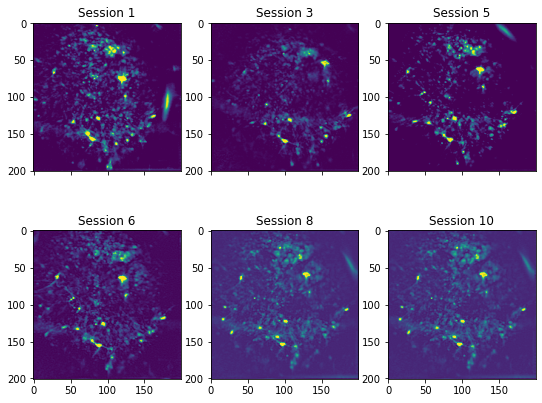

In [64]:
templates_name_1 = ['D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-9-D1/processed/2020-09-19/STD.png',
                  'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-9-D1/processed/2020-09-22/STD.png',
                  'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-9-D1/processed/2020-09-24/STD.png',
                  'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-9-D1/processed/2020-09-25/STD.png',
                  'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-9-D1/processed/2020-09-27/STD.png',
                  'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-9-D1/processed/2020-09-29/STD.png']
templates_name_3 = ['D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-12-D1/processed/2020-09-19/STD.png',
                    'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-12-D1/processed/2020-09-22/STD.png',
                    'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-12-D1/processed/2020-09-24/STD.png',
                    'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-12-D1/processed/2020-09-25/STD.png',
                    'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-12-D1/processed/2020-09-29/STD.png',
                    'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/OT-GC-12-D1/processed/2020-10-02/STD.png']
# normalization
templates = []
for im_name in templates_name_3:
    temp = io.imread(im_name)
    vmax = temp.max()
    temp = temp/vmax
    templates.append(temp)
# dimension of the images
dims = templates[0].shape

##### save figure ??? ######################
is_save = True
savedir = 'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/figures/OT-GC-12-D1/'
fig, axes = plt.subplots(2, 3,sharex = True,figsize=(9,7))
for i in range(2):
    for j in range(3):
        plt.sca(axes[i,j])
        try:
            plt.imshow(templates[i*3+j])
            plt.gca().set_title('Session {}'.format(sessions[i*3+j]))
        except:
            pass
if is_save:
    name = savedir+'templates_comparison_{}.png'.format(len(sessions))
    plt.savefig(name, bbox_inches="tight", dpi = 200)

## Use `register_multisession()`

The function `register_multisession()` requires 3 arguments:
- `A`: A list of ndarrays or scipy.sparse.csc matrices with (# pixels X # component ROIs) for each session
- `dims`: Dimensions of the FOV, needed to restore spatial components to a 2D image
- `templates`: List of ndarray matrices of size `dims`, template image of each session

In [65]:
spatial_union, assignments, matchings = register_multisession(A=spatial, dims=dims, templates=templates)
assignments

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\sci

array([[ 0., nan, nan, nan, nan, nan],
       [ 1., nan,  4., nan, nan, nan],
       [ 2., nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan, 42.],
       [nan, nan, nan, nan, nan, 46.],
       [nan, nan, nan, nan, nan, 48.]])

## sort assignment according to number of NaN

In [66]:
order = np.argsort(np.sum(np.isnan(assignments),axis = 1))
assignments_new = assignments[order,:]
assignments = assignments_new.copy()

In [67]:
print(assignments[0:30])

[[nan 27. 32. 22. 27. 30.]
 [nan 13. 17. 13. 20. 18.]
 [37. nan 38. 30. 42. 43.]
 [27. 22. 29. 25. nan 31.]
 [nan 11. 19. nan 17. 17.]
 [nan 12. 22. nan 15. 15.]
 [nan nan 39. 27. 36. 40.]
 [30. nan 36. nan 34. 36.]
 [21. 18. 23. 18. nan nan]
 [20. 16. nan 19. 23. nan]
 [nan 35. 42. 31. 45. nan]
 [nan  7. nan  8.  8.  4.]
 [nan nan 18. 15. 18. 16.]
 [nan nan 15. 10. 10.  7.]
 [nan nan nan 24. 24. 24.]
 [nan nan 40. nan 37. 34.]
 [42. nan 43. nan nan 44.]
 [33. 28. nan nan 41. nan]
 [nan 21. 26. nan 21. nan]
 [nan nan 25. 20. nan 21.]
 [25. nan 30. nan 31. nan]
 [24. nan nan nan 25. 22.]
 [nan nan nan 14. 12. 10.]
 [nan 30. nan nan 35. 38.]
 [nan 17. 24. nan nan 20.]
 [nan 15. nan nan 14. 14.]
 [nan 10. 16. nan 11. nan]
 [22. 24. nan nan nan 29.]
 [nan  9. 14. nan nan nan]
 [nan nan nan  3. nan  0.]]


The function returns 3 variables for further analysis:
- `spatial_union`: csc_matrix (# pixels X # total distinct components), the union of all ROIs across all sessions aligned to the FOV of the last session.
- `assignments`: ndarray (# total distinct components X # sessions). `assignments[i,j]=k` means that component `k` from session `j` has been identified as component `i` from the union of all components, otherwise it takes a `NaN` value. Note that for each `i` there is at least one session index `j` where `assignments[i,j]!=NaN`.(Selina: The neurons identified on the first session is the standard, then other sessions match to that. If more is identified on other sessions, they will be put at the tail of the list, starting from the second session all the way to the last session.)
- `matchings`: list of (# sessions) lists. Saves `spatial_union` indices of individual components in each session. `matchings[j][k] = i` means that component `k` from session `j` is represented by component `i` in the union of all components `spatial_union`. In other words `assignments[matchings[j][k], j] = k`.(Selina:this can be used for match traces)

## Post-alignment screening

The three outputs can be used to filter components in various ways. For example we can find the components that were active in at least a given a number of sessions. For more examples, check [this script](https://github.com/flatironinstitute/CaImAn/blob/master/use_cases/eLife_scripts/figure_9/Figure_9_alignment.py) that reproduces the results of [Figure 9, as presented in our eLife paper](https://elifesciences.org/articles/38173#fig9).

The shape of the filtered assignments matrix is:  (37, 6)


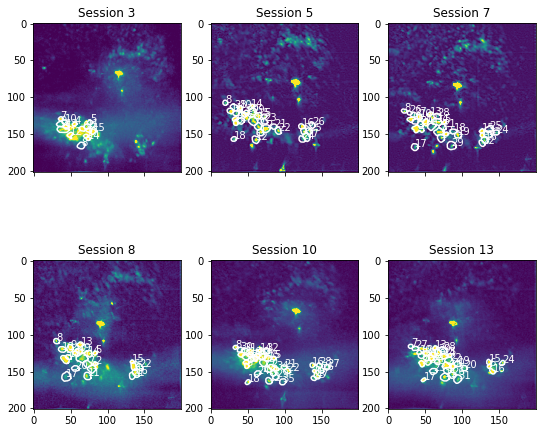

In [46]:
# Filter components by number of sessions the component could be found

n_reg = 3  # minimal number of sessions that each component has to be registered in

# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions 
# (selina: confirmed, a row is a specific component in assignment matrix. and matching can tell you the kth component in J session is the ith component.)
assignments_filtered = np.array(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg], dtype=int);
print('The shape of the filtered assignments matrix is: ',assignments_filtered.shape)

# Use filtered indices to select the corresponding spatial components
# (Selina: if I don't use 6 then you also need to include the neurons doesn't show up on the first column. find all the original index for those rows stilll exist in the filtered matrix) )


fig, axes = plt.subplots(2, 3,sharex = True,figsize=(9,8))
for i in range(2):
    for j in range(3):
        plt.sca(axes[i,j])
        try:
            plt.imshow(templates[i*3+j])
            ## this is for n_reg <total number of sessions
            cleanedList = [x for x in assignments_filtered[:, i*3+j] if x != -2147483648]
            spatial_filtered = spatial[i*3+j][:, cleanedList]
            # Plot spatial components of the selected components on the template of the last session    
            visualization.plot_contours(spatial_filtered, templates[i*3+j])
            plt.gca().set_title('Session {}'.format(sort_file_index[i*3+j]))
        except:
            pass
# name = savedir+'overlay_comparison_{}sessions'.format(n_reg)
# plt.savefig(name, bbox_inches="tight", dpi = 400)


## Load behavioral and imaging pickled dataframes

In [2]:
def pickle_dict(df,path,filename):
    try:
        os.makedirs(path) # create the path first
    except FileExistsError:
        print('the path exist.')
    filename = path +'/{}.pickle'.format(filename)
    with open(filename, 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('save to pickle done!')


def load_pickleddata(filename):
    
    with open(filename, 'rb') as handle:
        df = pickle.load(handle)
    return df
def getKeys(dict): 
    list = [] 
    for key in dict.keys(): 
        list.append(key) 
    return list
def find_align_position(framenum_trialtype,frameswitch_trialtype):
    pre = []
    post = []
    for i in range(len(framenum_trialtype)):
        pre_temp = frameswitch_trialtype[i][0]
        post_temp = framenum_trialtype[i] - pre_temp
        pre.append(pre_temp)
        post.append(post_temp)
    max_pre = np.max(pre)
    max_post = np.max(post)
    len_nan = int(max_pre+max_post+1)
    return max_pre, max_post,len_nan

def subtract_baseline(stacked_matrix,soleopen_frame):
    
    sub = stacked_matrix.copy()
    for i in range(stacked_matrix.shape[0]):
        value = sub[i,0:int(soleopen_frame)]
        
        if len(value) >1:
            avg = value.mean()
            
        else:
            avg = 0
        
        sub[i,:] =  sub[i,:] - avg
        
    return sub

def create_3d_matrix(num_neurons, len_nan, num_go, odor_on_frame, temp_traces, 
                     index_trialtype, framenum_trialtype,frameswitch_trialtype): 
    ### for the xxx_trialtype, the type has to be specified when give inputs
    a = np.full([num_neurons, len_nan, num_go], np.nan)
    
    for i, index in enumerate(index_trialtype):
        start_p = int(odor_on_frame-frameswitch_trialtype[i][0])
        end_p = int(start_p + framenum_trialtype[i])
        sub = subtract_baseline(temp_traces['Trial{}'.format(index)], frameswitch_trialtype[i][0])
        
        a[:,start_p:end_p,i] = sub
    return a
 

def slice_signal_to_trial(temp_traces,df): 
    # signal matrix: neurons * temporal traces; frames: the colomn for frame length, df.frame
    F_dff_individualtrials = {}
    cum_frames = np.cumsum(df.frames.values)
    cum_frames = np.insert(cum_frames, 0,0)
    for i in range(len(cum_frames)-1):
        F_dff_individualtrials['Trial'+str(i)] = temp_traces[:,cum_frames[i]:cum_frames[i+1]].copy()
        
    return F_dff_individualtrials

def generate_aligned_matrix(Dict,F_dff,trialtype = 'go'):
    multi_soleopen_frame = []
    aligned_multi_F_dff_list = []
    for i,big_dict in enumerate(Dict):
        
        df_original = big_dict['behavior_original_df']
        df_all_drop = big_dict['behavior_dropped_df']
        F_dff_individual_trials = big_dict['temp_traces_trial_dict']
        dict_index_trialtype = big_dict['dict_index_trialtype']
        dict_framenum_trialtype = big_dict['dict_framenum_trialtype']
        
        dict_frameswitch_trialtype = big_dict['dict_frameswitch_trialtype']
        print(getKeys(dict_index_trialtype)) 
        trialtype = input('trialtype: (type none if pass) ')
        if trialtype == 'none':
            aligned_multi_F_dff_list.append(None)
            multi_soleopen_frame.append(None)
            continue
        index_trialtype = dict_index_trialtype[trialtype] 
        framenum_trialtype = dict_framenum_trialtype[trialtype] 
        frameswitch_trialtype = dict_frameswitch_trialtype[trialtype] 
        print(i)

        odor_on_frame,max_post_odor_frame,len_nan = find_align_position(framenum_trialtype,frameswitch_trialtype)
        num_go = len(framenum_trialtype)
        
        num_neurons = F_dff[i].shape[0]
        temp_traces_dict = slice_signal_to_trial(F_dff[i],df_original)

        order = np.argsort(index_trialtype)
        index_trialtype = np.sort(index_trialtype)
        framenum_trialtype = [ framenum_trialtype[i] for i in order]
        frameswitch_trialtype = [ frameswitch_trialtype[i] for i in order]
        F_dff_matrix = create_3d_matrix(num_neurons, len_nan, num_go, odor_on_frame, temp_traces_dict, index_trialtype, framenum_trialtype,frameswitch_trialtype)
        aligned_multi_F_dff_list.append(F_dff_matrix)
        multi_soleopen_frame.append(odor_on_frame)
    return aligned_multi_F_dff_list,multi_soleopen_frame


In [71]:
# Dict for all sessions of behavioral dicts
Dict = []
for filename in sort_filenames:
    big_dict = load_pickleddata(filename[:-5]+'.pickle')
    Dict.append(big_dict)
    print(filename[:-5]+'.pickle loaded')

D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/03_2020-09-19_cond1.pickle loaded
D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/05_2020-09-22_cond3.pickle loaded
D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/07_2020-09-24_cond5.pickle loaded
D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/08_2020-09-25_deg1.pickle loaded
D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/011_2020-09-29_deg3.pickle loaded
D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/OT-GC-12-D1/013_2020-10-02_deg5.pickle loaded


## Create multiplt aligned df/f matrix for each session (list format - neurons x time x trials)

In [72]:
# baseline has been ssubtracted
aligned_multi_F_dff_go,multi_soleopen_frame_go = generate_aligned_matrix(Dict, denoised_dff, 'go')
print('sessions of go:', len(aligned_multi_F_dff_go))

['go_omit', 'background', 'go', 'no_go']
trialtype: (type none if pass) go
0
['go', 'no_go', 'background', 'go_omit']
trialtype: (type none if pass) go
1
['no_go', 'background', 'go', 'go_omit']
trialtype: (type none if pass) go
2
['no_go', 'unpred_water', 'go', 'go_omit', 'background']
trialtype: (type none if pass) go
3
['unpred_water', 'no_go', 'go', 'background', 'go_omit']
trialtype: (type none if pass) go
4
['background', 'unpred_water', 'no_go', 'go_omit', 'go']
trialtype: (type none if pass) go
5
sessions of go: 6


In [74]:
nogo_aligned_multi_F_dff,nogo_multi_soleopen_frame = generate_aligned_matrix(Dict, denoised_dff, 'nogo')
print('sessions of no go:', len(nogo_aligned_multi_F_dff))

['go_omit', 'background', 'go', 'no_go']
trialtype: (type none if pass) no_go
0
['go', 'no_go', 'background', 'go_omit']
trialtype: (type none if pass) no_go
1
['no_go', 'background', 'go', 'go_omit']
trialtype: (type none if pass) no_go
2
['no_go', 'unpred_water', 'go', 'go_omit', 'background']
trialtype: (type none if pass) no_go
3
['unpred_water', 'no_go', 'go', 'background', 'go_omit']
trialtype: (type none if pass) no_go
4
['background', 'unpred_water', 'no_go', 'go_omit', 'go']
trialtype: (type none if pass) no_go
5
sessions of no go: 6


In [75]:
goomit_aligned_multi_F_dff,goomit_multi_soleopen_frame = generate_aligned_matrix(Dict, denoised_dff, 'go_omit')
print('sessions of go omit:', len(goomit_aligned_multi_F_dff))

['go_omit', 'background', 'go', 'no_go']
trialtype: (type none if pass) go_omit
0
['go', 'no_go', 'background', 'go_omit']
trialtype: (type none if pass) go_omit
1
['no_go', 'background', 'go', 'go_omit']
trialtype: (type none if pass) go_omit
2
['no_go', 'unpred_water', 'go', 'go_omit', 'background']
trialtype: (type none if pass) go_omit
3
['unpred_water', 'no_go', 'go', 'background', 'go_omit']
trialtype: (type none if pass) go_omit
4
['background', 'unpred_water', 'no_go', 'go_omit', 'go']
trialtype: (type none if pass) go_omit
5
sessions of go omit: 6


In [76]:
### in conditioning days, background cannot be used!!!! put none for condition day background. cannot be aligned
bg_aligned_multi_F_dff,bg_multi_soleopen_frame = generate_aligned_matrix(Dict, denoised_dff, 'background')
print('sessions of background:', len(bg_aligned_multi_F_dff))

['go_omit', 'background', 'go', 'no_go']
trialtype: (type none if pass) none
['go', 'no_go', 'background', 'go_omit']
trialtype: (type none if pass) none
['no_go', 'background', 'go', 'go_omit']
trialtype: (type none if pass) none
['no_go', 'unpred_water', 'go', 'go_omit', 'background']
trialtype: (type none if pass) unpred_water
3
['unpred_water', 'no_go', 'go', 'background', 'go_omit']
trialtype: (type none if pass) unpred_water
4
['background', 'unpred_water', 'no_go', 'go_omit', 'go']
trialtype: (type none if pass) unpred_water
5
sessions of background: 6


In [ ]:
aligned_multi_F_dff_go,multi_soleopen_frame_go,
goomit_aligned_multi_F_dff,goomit_multi_soleopen_frame,
nogo_aligned_multi_F_dff,nogo_multi_soleopen_frame,
bg_aligned_multi_F_dff,bg_multi_soleopen_frame,

## get number of trials and mean and standard deviation of each neuron for each session

In [50]:
def mean_std_n_of_multidff(aligned_multi_F_dff):  
    mean = []
    std = []
    n = []
    for matrix in aligned_multi_F_dff:
        if matrix is not None:
            mean_act = np.nanmean(matrix,axis = 2)
            n_trials = matrix.shape[2]
            std_act = np.nanstd(matrix,axis = 2)
            mean.append(mean_act)
            std.append(std_act)
            n.append(n_trials)
        else:
            mean.append(None)
            mean.append(None)
            mean.append(None)
    return mean,std,n

In [51]:
mean_multi, std_multi, n_multi = mean_std_n_of_multidff(aligned_multi_F_dff_go)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [15]:
nogo_mean_multi, nogo_std_multi, nogo_n_multi = mean_std_n_of_multidff(nogo_aligned_multi_F_dff)

NameError: name 'nogo_aligned_multi_F_dff' is not defined

In [62]:
def display_sessions(alignments,dff_go,soleopen_frame_go,
                     dff_goomit=None,soleopen_frame_goomit=None,
                     dff_nogo=None,soleopen_frame_nogo=None,
                     dff_bgrw=None,soleopen_frame_bgrw=None,trialtype = 'go', sep_index = 2,name = 'test'):
    from matplotlib.cm import get_cmap
   
    col = alignments.shape[0] #25
    row = alignments.shape[1] #5
    
    fig, axes = plt.subplots(row, col,sharex = True,figsize=(2*col,24))
    ax = fig.add_axes([0.91, 0.15, .1, 0.7])
    colorcode = {'go':'#E0A8BD','go_omit':'#F9CB32' ,'OdorReward':'#E0A8BD','OdorNReward':'#F9CB32' ,
                 'no_go':'#87DEC1','unpred_water':'#9272BF'}
    plt.suptitle('')

    for col_plot in range(col):
        for row_plot in range(row):

            # odor shaded area
            axes[row_plot, col_plot].fill_between([1,2], [100,100],[-100,-100],facecolor="grey", color='grey', alpha=0.1)   
            # lick shaded area
            axes[row_plot, col_plot].fill_between([4.5,4.58], [100,100],[-100,-100],facecolor="#3083D1", color='#3083D1',alpha=0.2)
            try:
                # statistics
                    # plot 1
                type1 = 'go'
                window_pre = 5
                window_post = 30

                #calculation    
                mu = np.nanmean(dff_go[row_plot][alignments[col_plot,row_plot],:,:].T,axis=0)[int(soleopen_frame_go[row_plot] - window_pre): int(soleopen_frame_go[row_plot] + window_post)]
                sigma = np.nanstd(dff_go[row_plot][alignments[col_plot,row_plot],:,:].T,axis=0)[int(soleopen_frame_go[row_plot] - window_pre): int(soleopen_frame_go[row_plot] + window_post)]
    #             lines = dff_go[row_plot][i,int(soleopen_frame_go[row_plot] - window_pre): int(soleopen_frame_go[row_plot] + window_post),:]
                adjusted_sigma = sigma/np.sqrt(dff_go[row_plot].shape[2])
                x = np.linspace(0,len(mu)/5,len(mu))
                    # plot
                axes[row_plot, col_plot].plot(x,mu, lw=2,  color = colorcode[type1],label = type1)
                #axes[row_plot, col_plot].plot(x,lines, lw=1,  color = 'grey',alpha = 0.2)
                axes[row_plot, col_plot].fill_between(x,mu+adjusted_sigma, 
                                                      mu-adjusted_sigma, facecolor= colorcode[type1], alpha=0.4)   

                # plot2
                type2 = 'go_omit'
                window_pre = 5
                window_post = 30

                if dff_goomit is not None:
                    mu = np.nanmean(dff_goomit[row_plot][alignments[col_plot,row_plot],:,:].T,axis=0)[int(soleopen_frame_goomit[row_plot] - window_pre): int(soleopen_frame_goomit[row_plot] + window_post)]
                    sigma = np.nanstd(dff_goomit[row_plot][alignments[col_plot,row_plot],:,:].T,axis=0)[int(soleopen_frame_goomit[row_plot] - window_pre): int(soleopen_frame_goomit[row_plot] + window_post)]
    #                 lines = dff_goomit[row_plot][i,int(soleopen_frame_goomit[row_plot] - window_pre): int(soleopen_frame_goomit[row_plot] + window_post),:]
                    x = np.linspace(0,len(mu)/5,len(mu))
                        # plot
                    axes[row_plot, col_plot].plot(x,mu, lw=2,  color = colorcode[type2],label = type2)
                    axes[row_plot, col_plot].fill_between(x,mu+adjusted_sigma, 
                                                          mu-adjusted_sigma, facecolor= colorcode[type2], alpha=0.4)   

                # plot3
                type3 = 'no_go'

                window_pre = 5
                window_post = 30

                if dff_nogo is not None:
                    mu = np.nanmean(dff_nogo[row_plot][alignments[col_plot,row_plot],:,:].T,axis=0)[int(soleopen_frame_nogo[row_plot] - window_pre): int(soleopen_frame_nogo[row_plot] + window_post)]
                    sigma = np.nanstd(dff_nogo[row_plot][alignments[col_plot,row_plot],:,:].T,axis=0)[int(soleopen_frame_nogo[row_plot] - window_pre): int(soleopen_frame_nogo[row_plot] + window_post)]
    #                 lines = dff_nogo[row_plot][i,int(soleopen_frame_nogo[row_plot] - window_pre): int(soleopen_frame_nogo[row_plot] + window_post),:]
                    x = np.linspace(0,len(mu)/5,len(mu))
                        # plot
                    axes[row_plot, col_plot].plot(x,mu, lw=2,  color = colorcode[type3],label = type3)
                    axes[row_plot, col_plot].fill_between(x,mu+adjusted_sigma, 
                                                          mu-adjusted_sigma, facecolor= colorcode[type3], alpha=0.4)  
                # plot3
                type4 = 'unpred_water'

                window_pre = 22.5
                window_post = 12.5

                if dff_bgrw is not None and row_plot > sep_index:
                    mu = np.nanmean(dff_bgrw[row_plot][alignments[col_plot,row_plot],:,:].T,axis=0)[int(soleopen_frame_bgrw[row_plot] - window_pre): int(soleopen_frame_bgrw[row_plot] + window_post)]
                    sigma = np.nanstd(dff_bgrw[row_plot][alignments[col_plot,row_plot],:,:].T,axis=0)[int(soleopen_frame_bgrw[row_plot] - window_pre): int(soleopen_frame_bgrw[row_plot] + window_post)]
    #                 lines = dff_bgrw[row_plot][i,int(soleopen_frame_bgrw[row_plot] - window_pre): int(soleopen_frame_bgrw[row_plot] + window_post),:]
                    x = np.linspace(0,len(mu)/5,len(mu))
                        # plot
                    axes[row_plot, col_plot].plot(x,mu, lw=2,  color = colorcode[type4],label = type4)
                    axes[row_plot, col_plot].fill_between(x,mu+adjusted_sigma, 
                                                          mu-adjusted_sigma, facecolor= colorcode[type4], alpha=0.4)  
            except:
                pass
            # info 

            axes[row_plot, col_plot].set_ylim(-0.3,0.38)
            axes[row_plot, col_plot].set_title(r'Neuron {}'.format(col_plot))
    #         axes[row_plot, col_plot].legend(loc='best',frameon=False)
            axes[row_plot, col_plot].set_xlabel('Time (s)' if row_plot == row-1 else '')
            axes[row_plot, col_plot].set_ylabel('dF/F (%)' if col_plot == 0 else '')
            handles, labels = axes[row_plot, col_plot].get_legend_handles_labels()
            if col_plot+row_plot*9 == 6:
                ax.legend(handles, labels,loc='center left',frameon=False,fontsize = 18)

            # decorations
            axes[row_plot, col_plot].tick_params(axis="both", which="both", labelleft=False if col_plot != 0 else True ,bottom=False, left = False, top = False, right = False) 
            axes[row_plot, col_plot].spines["top"].set_visible(False)    
            axes[row_plot, col_plot].spines["right"].set_visible(False)
            axes[row_plot, col_plot].spines["bottom"].set_visible(False if row_plot != row-1 else True)    
            axes[row_plot, col_plot].spines["left"].set_visible(False if col_plot != 0 else True)

    ax.tick_params(axis="both", which="both", labelleft=False,labelbottom=False,bottom=False, left = False, top = False, right = False)
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)    
    ax.spines["left"].set_visible(False)


    plt.savefig("{}.png".format(name), bbox_inches="tight", dpi = 400)

    plt.show()


## all trialtypes together

In [24]:
savename = 'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/figures/OT-GC-9-D1'

index = [i for i in range(len(assignments)) if np.sum(~np.isnan(assignments), axis=1)[i] in [8,9]]
assignments_selected = np.array(assignments[index], dtype=int)
display_sessions(assignments_selected,
                 aligned_multi_F_dff_go,multi_soleopen_frame_go,
                goomit_aligned_multi_F_dff,goomit_multi_soleopen_frame,
                nogo_aligned_multi_F_dff,nogo_multi_soleopen_frame,
                bg_aligned_multi_F_dff,bg_multi_soleopen_frame,
                 sep_index = 2,name = savename)

NameError: name 'goomit_aligned_multi_F_dff' is not defined

## selected trialtypes

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\li

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)

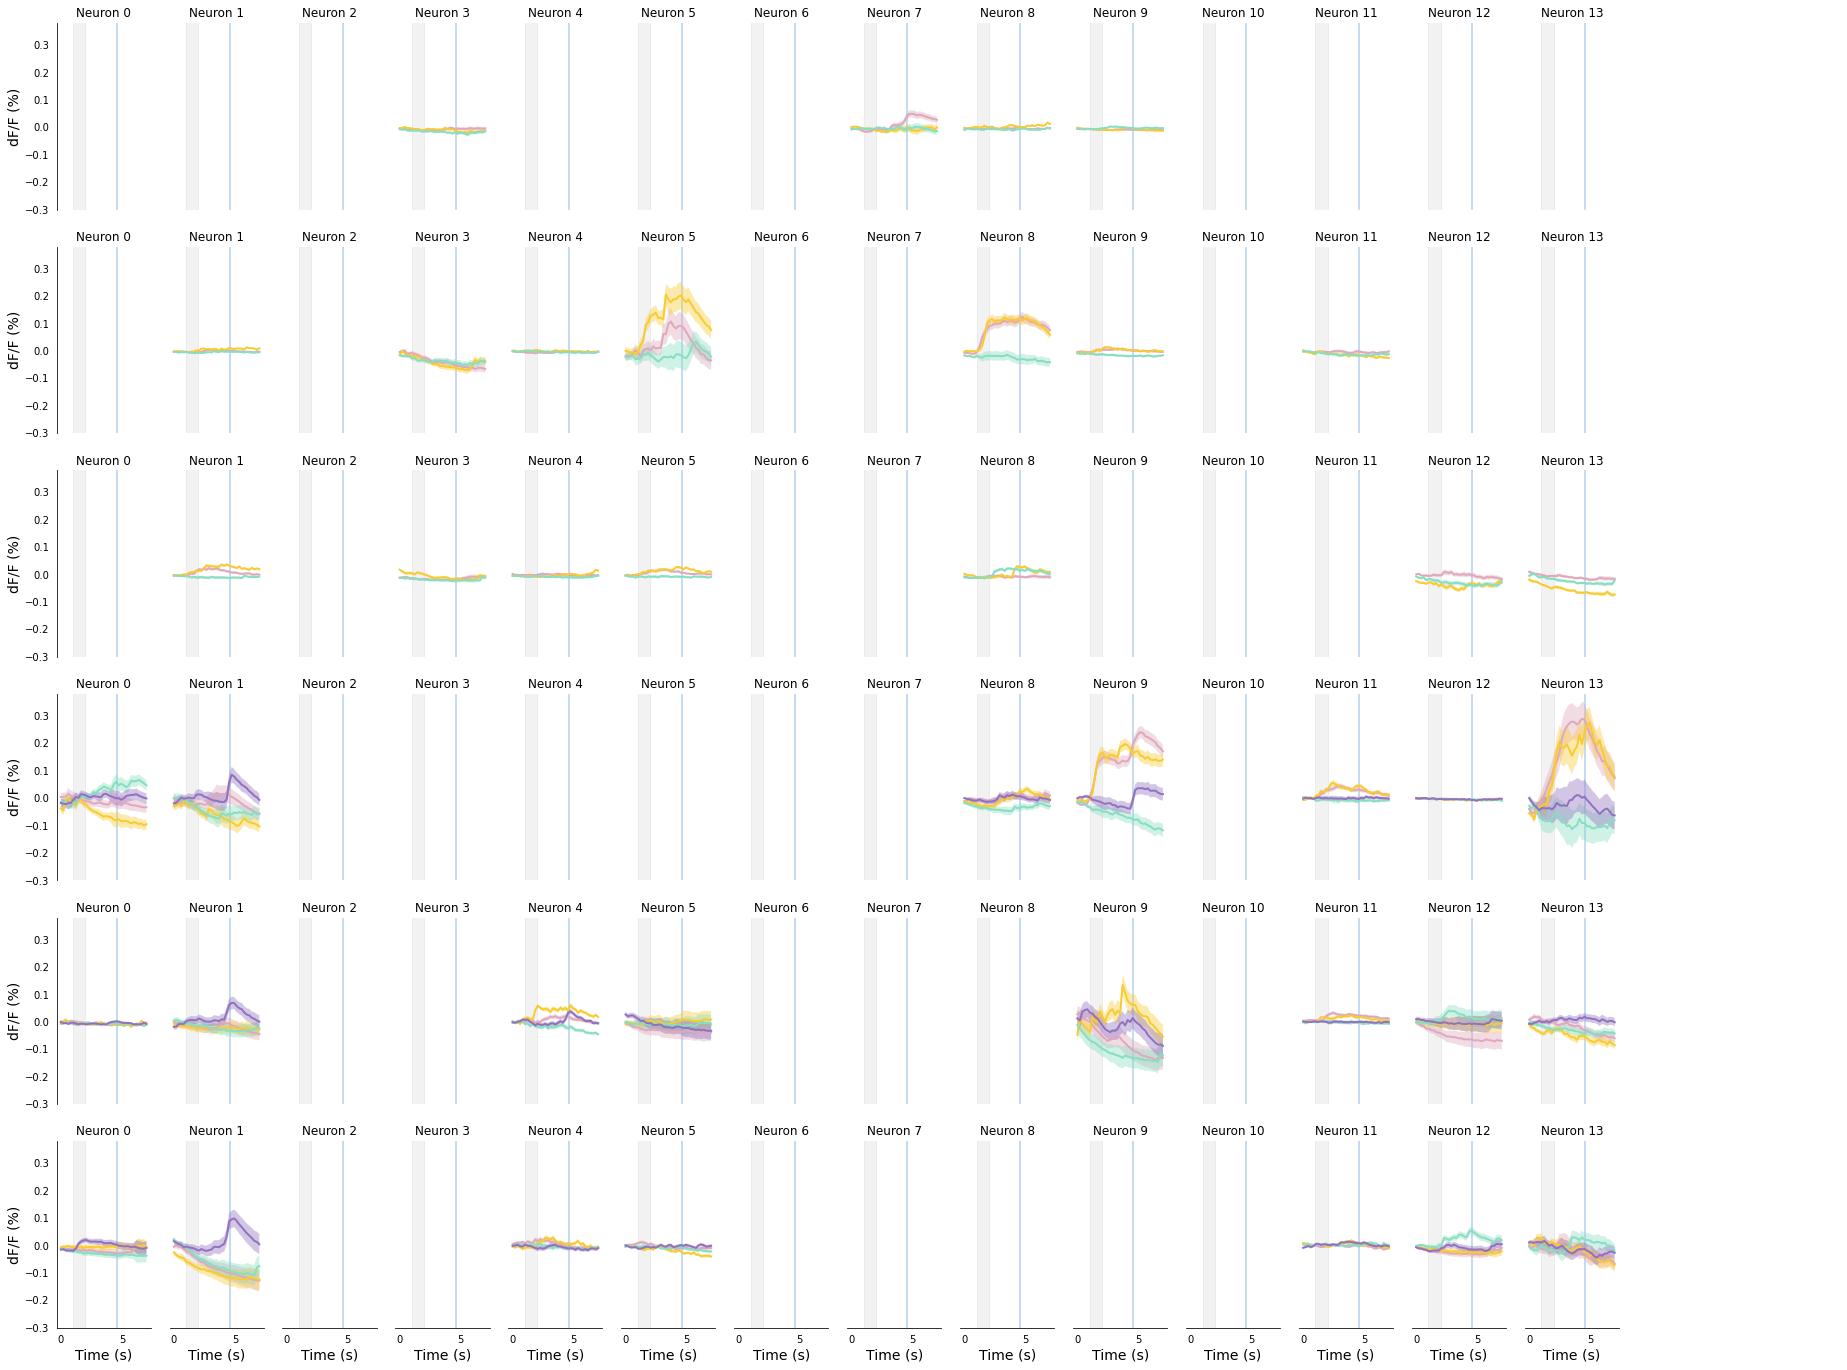

In [77]:
savename = 'D:/PhD/Microscope/imaging_data_20_09/D1_MSN/figures/OT-GC-12-D1/selected_above4sessions'

index = [i for i in range(len(assignments)) if np.sum(~np.isnan(assignments), axis=1)[i] in [4,5,6]]
assignments_selected = np.array(assignments[index], dtype=int)
# addition_select_index = [2,10,12,14,20,21,23]
# assignments_selected = np.array(assignments_selected[addition_select_index], dtype=int)
display_sessions(assignments_selected,aligned_multi_F_dff_go,multi_soleopen_frame_go,
                 dff_goomit=goomit_aligned_multi_F_dff,soleopen_frame_goomit=goomit_multi_soleopen_frame,
#                  dff_goomit=None,soleopen_frame_goomit=None,
#                      dff_nogo=None,soleopen_frame_nogo=None,
                dff_nogo=nogo_aligned_multi_F_dff,soleopen_frame_nogo=nogo_multi_soleopen_frame,
#                      dff_bgrw=None,soleopen_frame_bgrw=None,

                dff_bgrw=bg_aligned_multi_F_dff,soleopen_frame_bgrw=bg_multi_soleopen_frame,
                 sep_index = 2,name = savename)


C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\li

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\li

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)

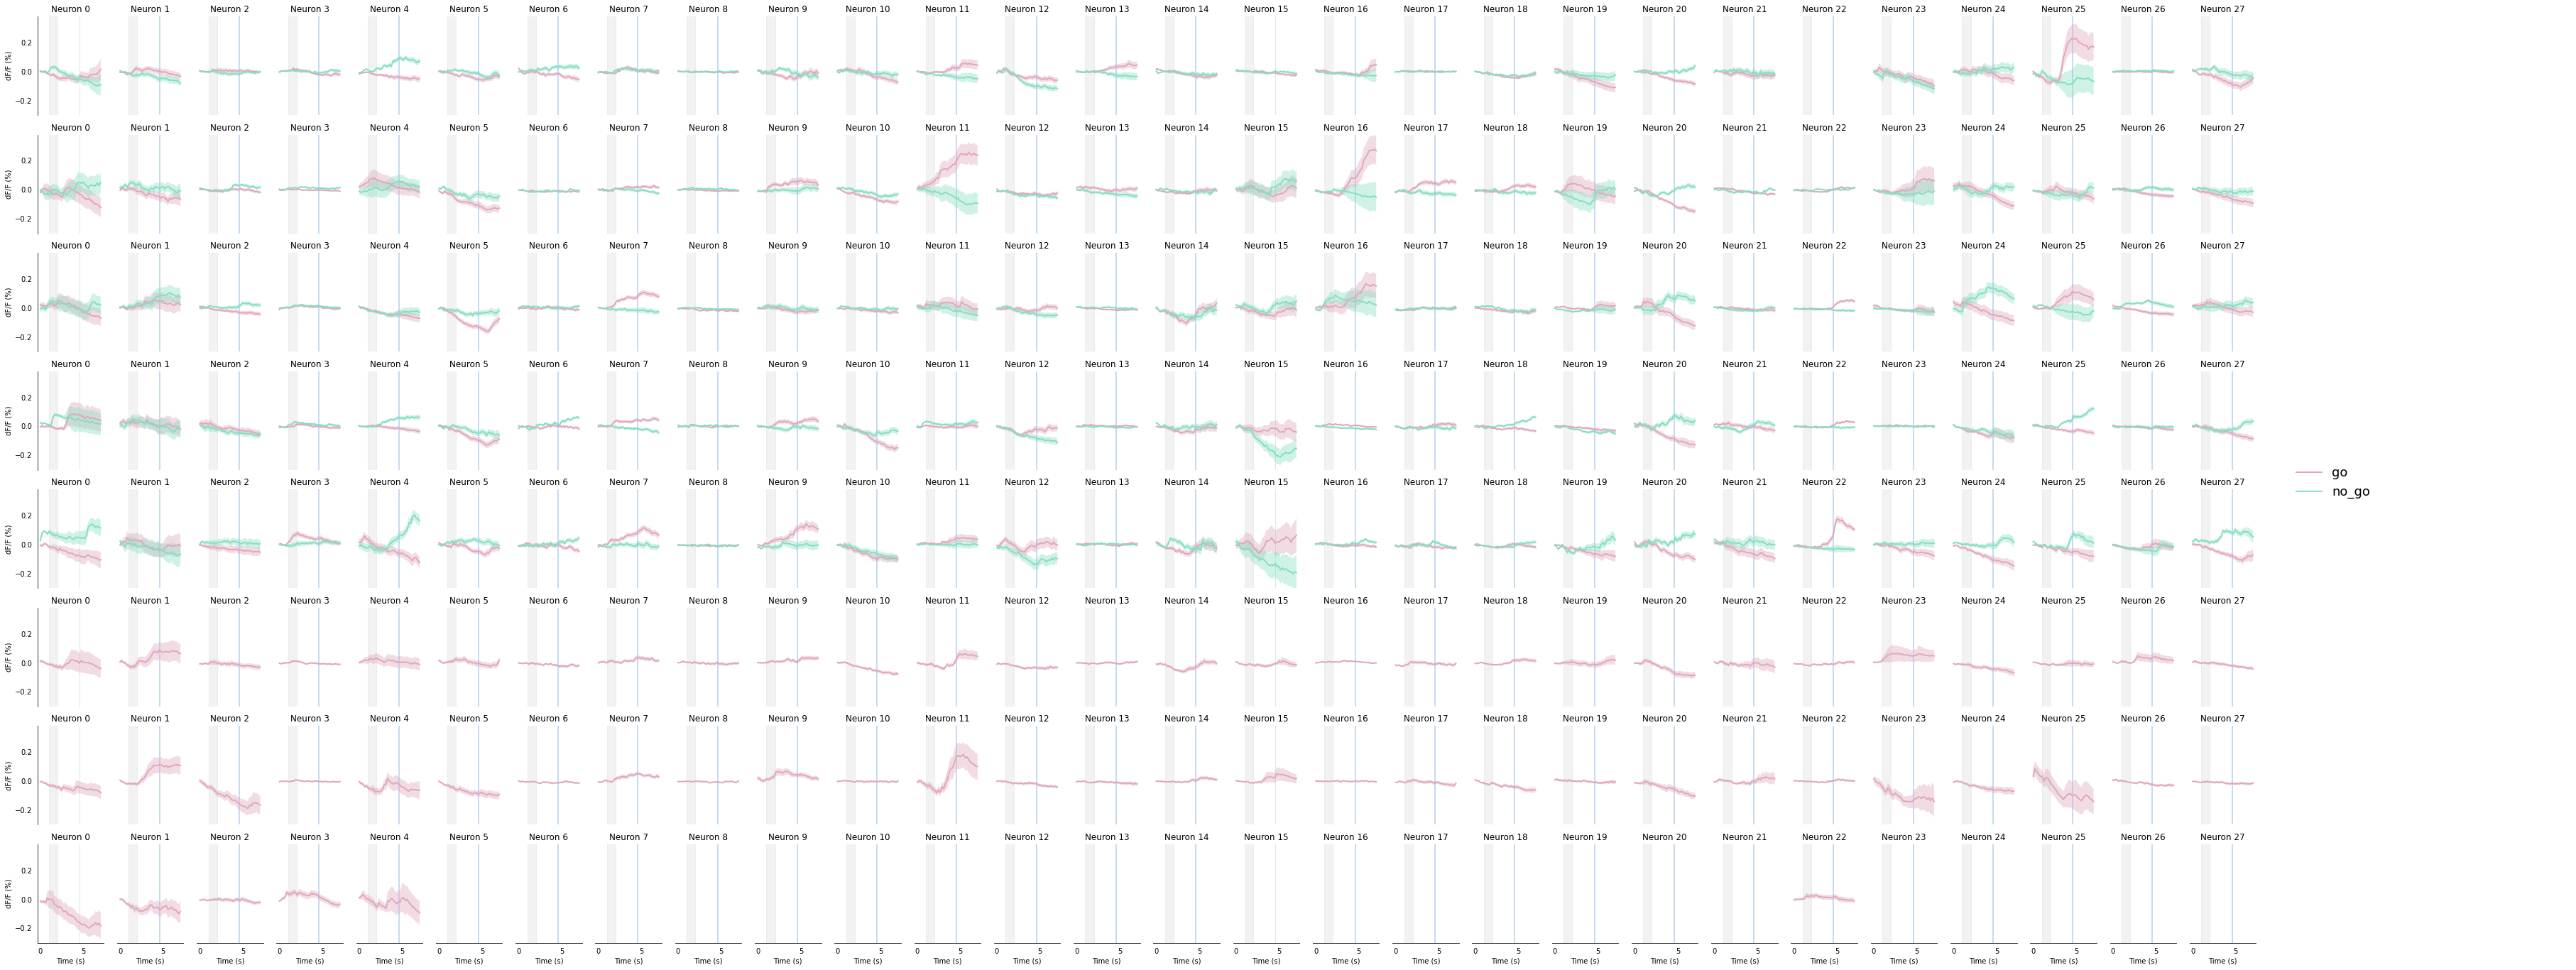

In [35]:
savename = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-3-new/response_go_nogo_7sessions'

index = [i for i in range(len(assignments)) if np.sum(~np.isnan(assignments), axis=1)[i] in [7,8]]
assignments_selected = np.array(assignments[index], dtype=int)
display_sessions(assignments_selected,aligned_multi_F_dff_go,multi_soleopen_frame_go,
#                  dff_goomit=goomit_aligned_multi_F_dff,soleopen_frame_goomit=goomit_multi_soleopen_frame,
                 dff_goomit=None,soleopen_frame_goomit=None,
#                      dff_nogo=None,soleopen_frame_nogo=None,
                dff_nogo=nogo_aligned_multi_F_dff,soleopen_frame_nogo=nogo_multi_soleopen_frame,
                     dff_bgrw=None,soleopen_frame_bgrw=None,

#                 dff_bgrw=bg_aligned_multi_F_dff,soleopen_frame_bgrw=bg_multi_soleopen_frame,
                 sep_index = 4,name = savename)


C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\li

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\li

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\li

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\li

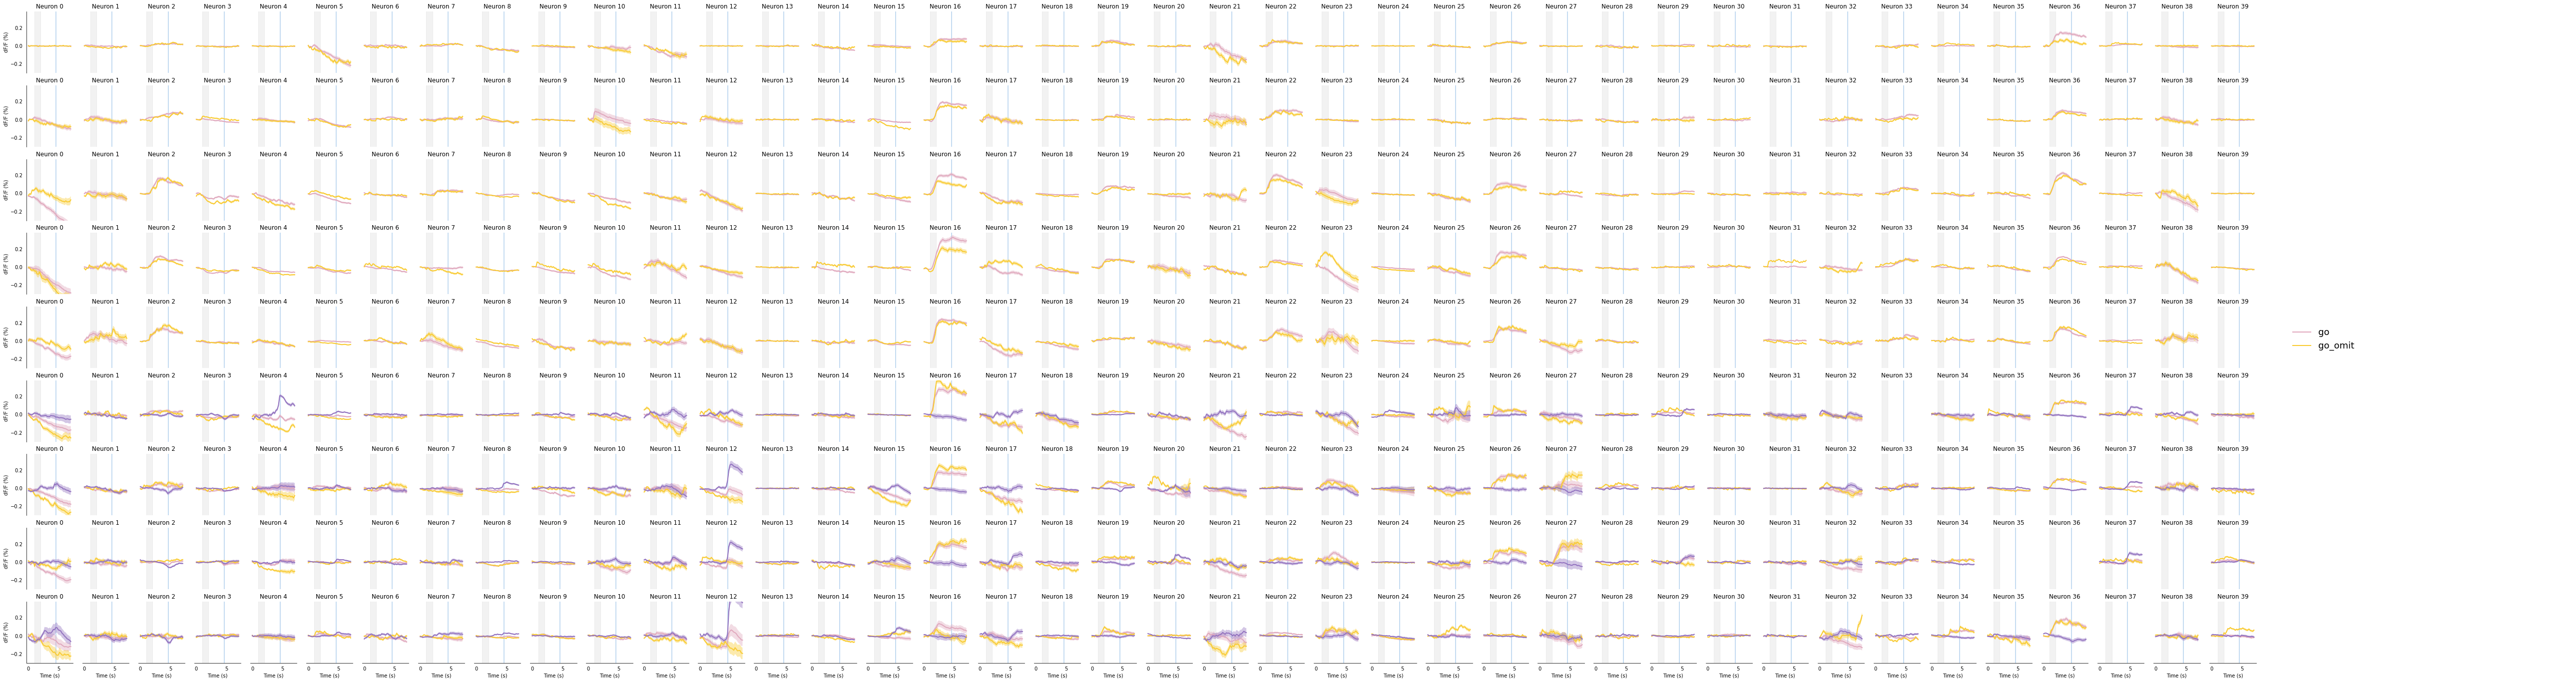

In [17]:
savename = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/test/response_go_bgrw_89sessions'

index = [i for i in range(len(assignments)) if np.sum(~np.isnan(assignments), axis=1)[i] in [8,9]]
assignments_selected = np.array(assignments[index], dtype=int)
display_sessions(assignments_selected,aligned_multi_F_dff_go,multi_soleopen_frame_go,
                 dff_goomit=goomit_aligned_multi_F_dff,soleopen_frame_goomit=goomit_multi_soleopen_frame,
#                  dff_goomit=None,soleopen_frame_goomit=None,
                     dff_nogo=None,soleopen_frame_nogo=None,
#                 dff_nogo=nogo_aligned_multi_F_dff,soleopen_frame_nogo=nogo_multi_soleopen_frame,
#                      dff_bgrw=None,soleopen_frame_bgrw=None,

                dff_bgrw=bg_aligned_multi_F_dff,soleopen_frame_bgrw=bg_multi_soleopen_frame,
                 sep_index = 4,name = savename)


# percentage of activated or inhibited cells

In [3]:
combined_dict = load_pickleddata('D:/PhD/Microscope/imaging_data_20_09/D1_MSN/result/combine/OT-GC-9and12_combined_matrix.pickle')

In [4]:
combined_dict['go_ave_mat']

{'go_ave_mat': [array([[ 0.10535822,  0.33514045,  0.03125138, ...,  0.40692648,
           0.4566643 ,  0.30505605],
         [ 0.21287227, -0.12133379,  0.33763273, ...,  0.54955384,
           0.50771073,  0.35682607],
         [ 0.56860351,  0.51765738,  0.38020408, ..., -0.3229558 ,
          -0.26769891, -0.39082314],
         ...,
         [-0.7556458 , -0.7599173 , -1.05928389, ..., -1.80726335,
          -1.7478487 , -1.73687809],
         [-0.36899369, -0.65162091, -0.64902571, ..., -1.05497231,
          -0.91908545, -0.92732285],
         [-0.13286836,  0.09901048, -0.17999419, ..., -1.77158847,
          -1.54628036, -1.79710262]]),
  array([[ 2.73546647e-02, -8.21090151e-03,  2.51644246e-01, ...,
           5.33470504e-01,  3.26914699e-01,  2.56777233e-01],
         [ 3.22168941e-01, -8.58486844e-03,  3.09251532e-01, ...,
           2.18406663e-01,  6.08291324e-01,  1.05952882e-01],
         [ 3.62060215e-03,  3.14399965e-01,  1.85625755e-01, ...,
           3.74908997e-0

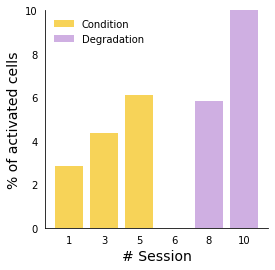

In [25]:
# percentage of all cells identified to go odor
Percent = []
for index in range(len(combined_dict['go_ave_mat'])):
    # mean_multi is for go odor
    x = combined_dict['go_ave_mat'][index][:,combined_dict['odor_on_frame']:combined_dict['odor_on_frame']+15]
#     activated cells
#     peaks = x.max(axis = 1)>10
#     # inhibited cells
    peaks = x.min(axis = 1)<-5
    
    percent = sum(peaks)/len(peaks)
    Percent.append(percent*100)

fig, ax = plt.subplots(figsize=(4,4))
# fig font settings

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## plot
x = np.array(range(6))
# activated cell
# colors = ['#E2AFC7']*3 + ['#83B291']*3
# inhibited cell
colors = ['#F7D358']*3 + ['#CFAFE2']*3 

label = ['Condition']*3+['Degradation']*3
labels = ['Condition','','','Degradation','','']


handles = [plt.bar(x[i], Percent[i], width=0.8,color=colors[i],label = labels[i]) for i in range(len(label))]
ax.set_xticks(x)
ax.set_xticklabels(combined_dict['sessions'])
ax.set_xlabel('# Session')
ax.set_ylabel('% of activated cells')
ax.set_ylim([0,10])

# decorations
ax.tick_params(axis="both", which="both",bottom=False, 
                                     left = False, top = False, right = False) 
ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(True)    
ax.spines["left"].set_visible(True)
plt.legend(loc = 2,frameon= False)
plt.savefig('D:/PhD/Microscope/imaging_data_20_09/D1_MSN/figures/combine/go_inhibited_thres-10.png', 
            bbox_inches="tight", dpi = 200)
plt.show()


In [9]:
len(combined_dict['go_ave_mat'])

6

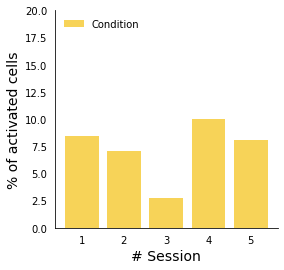

In [42]:
# percentage of all cells identified to go odor(warning: the number of neurons for each session is different)
Percent = []
activated = False
threshold = 0.06
for index in range(len(nogo_mean_multi)):
    # mean_multi is for go odor
    if nogo_mean_multi[index] is not None:
        x = nogo_mean_multi[index][:,int(nogo_multi_soleopen_frame[index]): int(nogo_multi_soleopen_frame[index] + 3.5*5)] # odor on to water delivery
    #     activated cells
        if activated:
            peaks = x.max(axis = 1)>threshold
        else:    
    #     # inhibited cells
            peaks = x.min(axis = 1)<-threshold

        percent = sum(peaks)/len(peaks)
        Percent.append(percent*100)

fig, ax = plt.subplots(figsize=(4,4))
# fig font settings

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## plot

x = np.array(range(len(Percent)))
# activated cell
if activated:
    colors = ['#E2AFC7']*len(Percent)
# inhibited cell
else:
    colors = ['#F7D358']*len(Percent)


labels = ['Condition']+['']*(len(Percent)-1)


handles = [plt.bar(x[i], Percent[i], width=0.8,color=colors[i],label = labels[i]) for i in range(len(Percent))]
ax.set_xticks(x)
ax.set_xticklabels(sort_file_index[:len(Percent)])
ax.set_xlabel('# Session')
ax.set_ylabel('% of activated cells')
ax.set_ylim([0,20])

# decorations
ax.tick_params(axis="both", which="both",bottom=False, 
                                     left = False, top = False, right = False) 
ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(True)    
ax.spines["left"].set_visible(True)
plt.legend(loc = 2,frameon= False)
plt.savefig('D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-3-new/{}_percent_nogo_THRES{}.png'.format('activated' if activated else 'inhibited',threshold), 
            bbox_inches="tight", dpi = 100)
plt.show()


In [326]:
mean_multi, std_multi, n_multi = mean_std_n_of_multidff(aligned_multi_F_dff_go)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [325]:
nogo_mean_multi, nogo_std_multi, nogo_n_multi = mean_std_n_of_multidff(nogo_aligned_multi_F_dff)

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


AxisError: axis 2 is out of bounds for array of dimension 0

In [49]:
# percentage of part of cell in 5 sessions
def percentage_(activated, mean_multi_dff,soleopen_frame,threshold,sep_index,xlabel,savepath,figname = 'test',assignments=None):


    Percent = []
    for index in range(len(mean_multi_dff)):  
        if assignments is not None:
            x = mean_multi_dff[index][assignments[:,index],:][:,int(soleopen_frame[index]): int(soleopen_frame[index] + 3.5*5)] # odor on to water delivery
        else:
            x = mean_multi_dff[index][:,int(soleopen_frame[index]): int(soleopen_frame[index] + 3.5*5)] # odor on to water delivery

        # activated cells
        if activated:
            peaks = x.max(axis = 1)>threshold
        # inhibited cells
        else:
            peaks = x.min(axis = 1)<-threshold
        percent = sum(peaks)/len(peaks)    
        Percent.append(percent*100)
    fig, ax = plt.subplots(figsize=(6,4))
    # fig font settings
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    ## plot
    x = np.array(range(len(mean_multi_dff)))
    # activated cell
    if activated:
        colors = ['#E2AFC7']*(sep_index+1) + ['#83B291']*(len(mean_multi_dff)-sep_index-1) 
    # inhibited cell
    else:
        colors = ['#F7D358']*(sep_index+1) + ['#CFAFE2']*(len(mean_multi_dff)-sep_index-1)  
    
    labels = ['Condition']+['']*sep_index+['Degradation']+['']*(len(mean_multi_dff)-sep_index-2) 
    handles = [plt.bar(x[i], Percent[i], width=0.8,color=colors[i],label = labels[i]) for i in range(len(labels))]
    ax.set_xticks(x)
    ax.set_xticklabels(xlabel)
    ax.set_xlabel('Session #')
    ax.set_ylabel('% of {} cells'.format('activated' if activated else 'inhibited'))
    ax.set_ylim([0,30])
    ax.tick_params(axis="both", which="both",bottom=False, 
                                         left = False, top = False, right = False)
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)    
    ax.spines["left"].set_visible(True)
    plt.legend(loc = 2,frameon= False)
    plt.savefig('{}/{}_9sessions_percent_{}_THRES{}.png'.format(savepath,'activated' if activated else 'inhibited',figname,threshold), 
                bbox_inches="tight", dpi = 100)
    plt.show()

activated=True
xlabel = ('1', '2', '3','4','5', '6','8','11')
savepath = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-3-new'
sep_index =4 # condition session -1
percentage_(activated, mean_multi,multi_soleopen_frame_go,0.05,sep_index,xlabel,savepath,figname='go_filtered',assignments = assignments_filtered)

IndexError: index -2147483648 is out of bounds for axis 0 with size 71

In [48]:
n_reg = 6  # minimal number of sessions that each component has to be registered in

# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions 
# (selina: confirmed, a row is a specific component in assignment matrix. and matching can tell you the kth component in J session is the ith component.)
assignments_filtered = np.array(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg], dtype=int);

IndexError: index -2147483648 is out of bounds for axis 0 with size 71

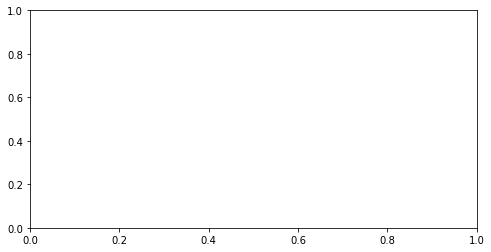

In [50]:
fig, ax = plt.subplots(figsize=(8, 4))
colormap = 'coolwarm'
cmap = mpl.cm.get_cmap(colormap)   # type: matplotlib.colors.ListedColormap
  # type: list
# plot the cumulative histogram
for index in range(len(mean_multi)):
    n_bins  = 70
    x = mean_multi[index][assignments_filtered[:,index],:][:,int(multi_soleopen_frame_go[index]): int(multi_soleopen_frame_go[index] + 3.5*5)] # odor on to water delivery

    peak_index = np.argmax(abs(x),axis = 1)
    peak = np.array([x[i,peak] for i,peak in enumerate(peak_index)])
#     tuple(map(int,np.array(cmap(position))*255))
    color = cmap(index/len(mean_multi))
    n, bins, patches = ax.hist(peak, n_bins, density=True, histtype='step',
                           cumulative=True, label='Session {}'.format(xlabel[index]),color = color,linewidth =2)



# tidy up the figure
ax.grid(False)
ax.legend(loc=2)
ax.set_title('Cumulative step histograms')
ax.set_ylim([0,1])
ax.set_xlabel('Peak df/f activites')
ax.set_ylabel('Likelihood of occurrence')
plt.savefig('D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-3-new/activities_cumulative_plot_go_filtered.png', 
            bbox_inches="tight", dpi = 100)
plt.show()

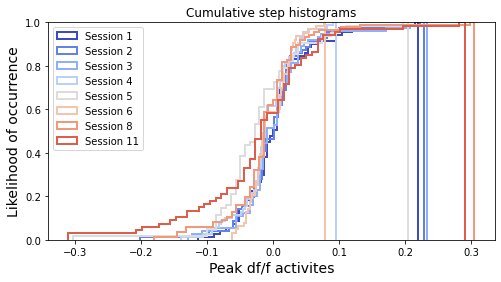

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))
colormap = "coolwarm"
cmap = mpl.cm.get_cmap(colormap)   # type: matplotlib.colors.ListedColormap
  # type: list
# plot the cumulative histogram
for index in range(len(mean_multi)):
    n_bins  = 70
    x = mean_multi[index][:,int(multi_soleopen_frame_go[index]): int(multi_soleopen_frame_go[index] + 3.5*5)] # odor on to water delivery

    peak_index = np.argmax(abs(x),axis = 1)
    peak = np.array([x[i,peak] for i,peak in enumerate(peak_index)])
#     tuple(map(int,np.array(cmap(position))*255))
    color = cmap(index/len(mean_multi))
    n, bins, patches = ax.hist(peak, n_bins, density=True, histtype='step',
                           cumulative=True, label='Session {}'.format(xlabel[index]),color = color,linewidth =2)



# tidy up the figure
ax.grid(False)
ax.legend(loc=2)
ax.set_title('Cumulative step histograms')
ax.set_ylim([0,1])
ax.set_xlabel('Peak df/f activites')
ax.set_ylabel('Likelihood of occurrence')
plt.savefig('D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-3-new/activities_cumulative_plot_go_9all.png', 
            bbox_inches="tight", dpi = 100)
plt.show()

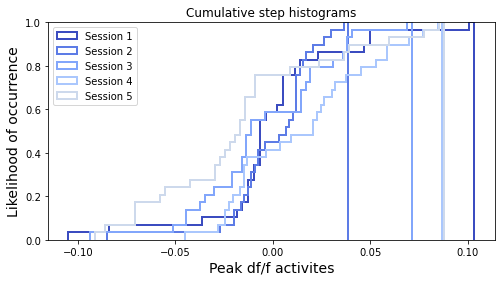

In [422]:
fig, ax = plt.subplots(figsize=(8, 4))
colormap = "coolwarm"
cmap = mpl.cm.get_cmap(colormap)   # type: matplotlib.colors.ListedColormap
  # type: list
# plot the cumulative histogram
for index in range(len(nogo_mean_multi)):
    n_bins  = 70
    if nogo_mean_multi[index] is not None:
        x = nogo_mean_multi[index][assignments_filtered[:,index],:][:,int(nogo_multi_soleopen_frame[index]): int(nogo_multi_soleopen_frame[index] + 3.5*5)] # odor on to water delivery

        peak_index = np.argmax(abs(x),axis = 1)
        peak = np.array([x[i,peak] for i,peak in enumerate(peak_index)])
    #     tuple(map(int,np.array(cmap(position))*255))
        color = cmap(index/len(sort_file_index))
        n, bins, patches = ax.hist(peak, n_bins, density=True, histtype='step',
                               cumulative=True, label='Session {}'.format(xlabel[index]),color = color,linewidth =2)



# tidy up the figure
ax.grid(False)
ax.legend(loc=2)
ax.set_title('Cumulative step histograms')
ax.set_ylim([0,1])
ax.set_xlabel('Peak df/f activites')
ax.set_ylabel('Likelihood of occurrence')
plt.savefig('D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-1-new/nogo_activities_cumulative_plot_9filtered.png', 
            bbox_inches="tight", dpi = 100)
plt.show()

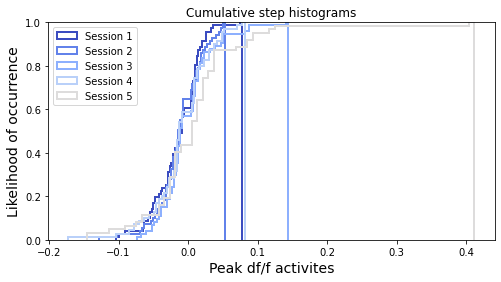

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
colormap = "coolwarm"
cmap = mpl.cm.get_cmap(colormap)   # type: matplotlib.colors.ListedColormap
  # type: list
# plot the cumulative histogram
for index in range(len(nogo_mean_multi)):
    n_bins  = 70
    if nogo_mean_multi[index] is not None:
        x = nogo_mean_multi[index][:,int(nogo_multi_soleopen_frame[index]): int(nogo_multi_soleopen_frame[index] + 3.5*5)] # odor on to water delivery

        peak_index = np.argmax(abs(x),axis = 1)
        peak = np.array([x[i,peak] for i,peak in enumerate(peak_index)])
    #     tuple(map(int,np.array(cmap(position))*255))
        color = cmap(index/len(sort_file_index))
        n, bins, patches = ax.hist(peak, n_bins, density=True, histtype='step',
                               cumulative=True, label='Session {}'.format(xlabel[index]),color = color,linewidth =2)



# tidy up the figure
ax.grid(False)
ax.legend(loc=2)
ax.set_title('Cumulative step histograms')
ax.set_ylim([0,1])
ax.set_xlabel('Peak df/f activites')
ax.set_ylabel('Likelihood of occurrence')
plt.savefig('D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-1-new/nogo_activities_cumulative_plot_9all.png', 
            bbox_inches="tight", dpi = 100)
plt.show()

In [102]:
def display_singleneuron(aligned_multi_F_dff,date, alignments,soleopen_frame,trialtype = 'go', name = 'test'):
    from matplotlib.cm import get_cmap
    
    col = 8
    row = int(np.ceil(alignments.shape[0]/col))
       
    fig, axes = plt.subplots(row, col,sharex = True,figsize=(40,5*row))
   
    colormap = "cool"
    cmap = mpl.cm.get_cmap(colormap) 

    for i in range(alignments.shape[0]):    
        row_plot = int(np.floor(i/col))
        col_plot = i%col
        
        # odor shaded area
        axes[row_plot, col_plot].fill_between([1,2], [10,10],[-10,-10],facecolor="grey", color='grey', alpha=0.1)   
        # lick shaded area
        axes[row_plot, col_plot].fill_between([4.5,4.58], [10,10],[-10,-10],facecolor="#3083D1", color='#3083D1',alpha=0.2)

        for j in range(alignments.shape[1]):


            mu = np.nanmean(aligned_multi_F_dff[j],axis=2)[:,int(soleopen_frame[j] - 5): int(soleopen_frame[j] + 6*5)]

            x = np.linspace(0,(mu.shape[1]-1)/5,mu.shape[1])
            try:
                color = cmap(j/alignments.shape[1])
                axes[row_plot, col_plot].plot(x,mu[int(alignments[i,j]),:], lw=2,  color = color, label = 'Session {}'.format(date[j]))
            except:
                pass

            

        
        axes[row_plot, col_plot].set_ylim(-0.3,0.4)


        axes[row_plot, col_plot].tick_params(axis="both", which="both", bottom=False, left = False, top = False, right = False) 
        axes[row_plot, col_plot].spines["top"].set_visible(False)    
        axes[row_plot, col_plot].spines["right"].set_visible(False)
        axes[row_plot, col_plot].spines["bottom"].set_visible(False if row_plot != row-1 else True)    
        axes[row_plot, col_plot].spines["left"].set_visible(False if col_plot != 0 else True)


        
        axes[row_plot, col_plot].legend(loc='best')
        axes[row_plot, col_plot].set_xlabel('Time (s)' if row_plot == row-1 else '')
        axes[row_plot, col_plot].set_ylabel('Normalized dF/F Activity' if col_plot == 0 else '')
    plt.savefig("{}.png".format(name), bbox_inches="tight", dpi = 400)

    plt.show()

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-

C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
C:\Users\qianl\Anaconda3\envs\caiwoman\lib\site-

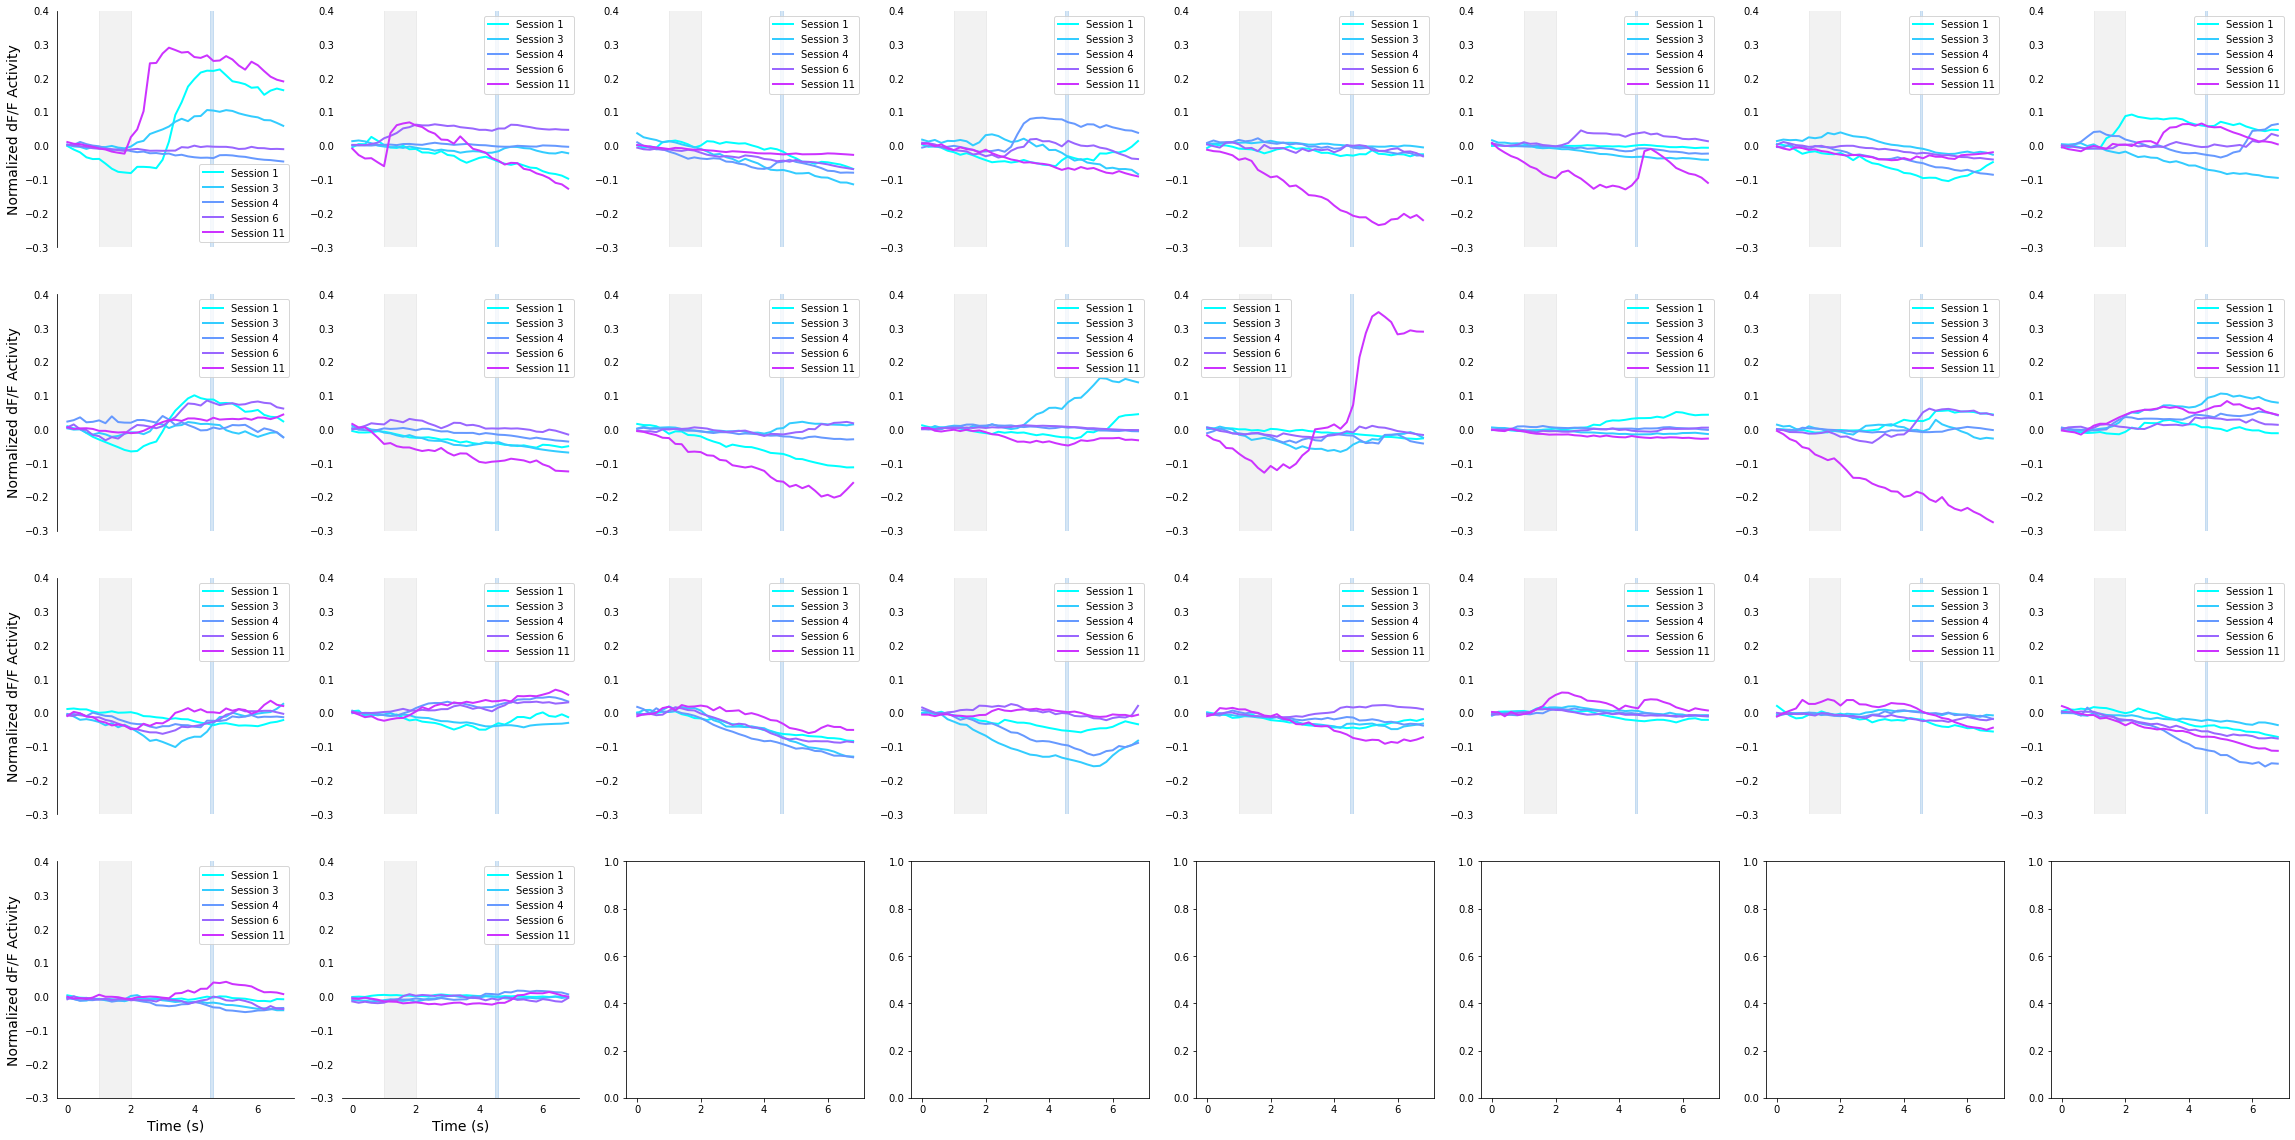

In [103]:
savename = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-3/all_neurons_go_over_sessions'
display_singleneuron(aligned_multi_F_dff,sort_file_index,assignments_filtered,multi_soleopen_frame, name = savename)

## fill contours according to activities level

In [53]:
def image2uni8(image):
    data = image.astype(np.float64) / image.max() # normalize the data to 0 - 1
    data = 255 * data # Now scale by 255
    uint8_im = data.astype(np.uint8)
    return uint8_im
    

def activity_dependent_overlay(spatial_session,background,activity, savepath,colormap = 'coolwarm'):
    # background image for overlay
    fig,axes = plt.subplots(figsize=(4,4))
    ax = fig.add_axes([.91, 0.15, .04, 0.7])
    bg = background.copy()
    bg = image2uni8(bg) # 0-255
    backtorgb = cv2.cvtColor(bg,cv2.COLOR_GRAY2RGB)

    # colormap 
    cmap = mpl.cm.get_cmap(colormap) 
    vmin = -0.2
    vmax = 0.2
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)  
   

    # dimension of image
    dims = background.shape
    # num of spatial footprints
    num_fp = spatial_session.shape[1]

    for i in range(num_fp):
        # convert one sparse matix saved spatial footprint to a image
        im_fp = np.reshape(spatial_session[:,i].toarray(),dims, order = 'F') # day 1, footprint 0 
        im_fp = image2uni8(im_fp) # 0-255

        # convert the grayscale image to binary image
        thresh, im_bw = cv2.threshold(im_fp, 50, 255, cv2.THRESH_BINARY) #im_bw: binary image    
        # find contours
        contours, hierarchy = cv2.findContours(im_bw,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        # find color position
        position = (np.min([vmax,np.max([activity[i],vmin])])-vmin)/(vmax-vmin)
        
        color = tuple(map(int,np.array(cmap(position))*255)) # position of the color 0.5
        new_img = cv2.drawContours(backtorgb, contours, -1, color, thickness = -1) # thickness -1 fill
    axes.imshow(new_img)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm,ticks=[vmin, 0, vmax], orientation='vertical')
    cb.ax.set_yticklabels(['<'+str(vmin), '0', '>'+str(vmax)])
    plt.savefig(savepath, bbox_inches="tight", dpi = 300,transparent = True)
    
    

In [390]:
sort_file_index

array([ 1,  2,  3,  4,  5,  6,  8,  9, 10])

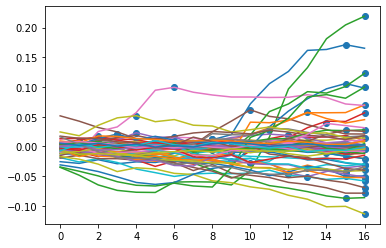

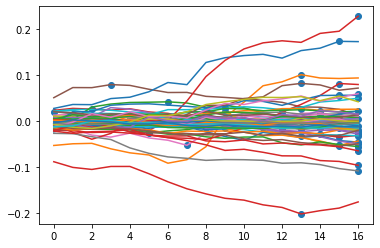

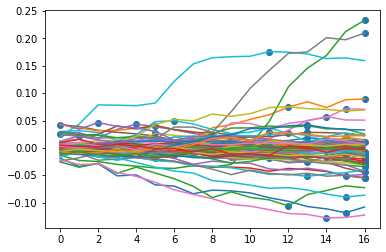

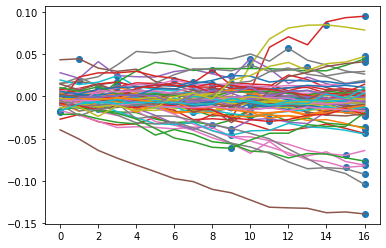

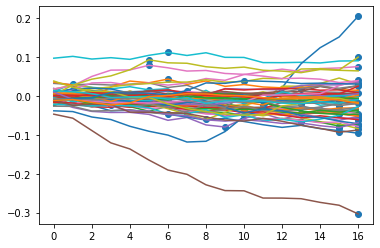

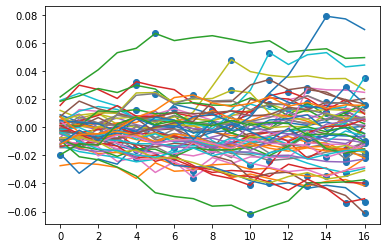

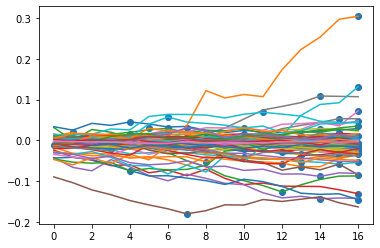

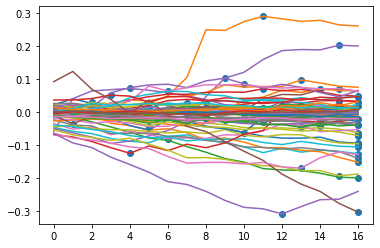

In [54]:
## go odor

Activities = []
for index in range(len(mean_multi)):
    # 0.4s after odor onset to remove some high value at the beginning
    x = mean_multi[index][:,int(multi_soleopen_frame_go[index]): int(multi_soleopen_frame_go[index] + 3.5*5)]
    peak_index = np.argmax(abs(x),axis = 1)
    peak = np.array([x[i,peak] for i,peak in enumerate(peak_index)])
    Activities.append(peak)
    plt.figure()
    plt.plot(x.T)
    plt.scatter(peak_index,peak)
    plt.show()
        

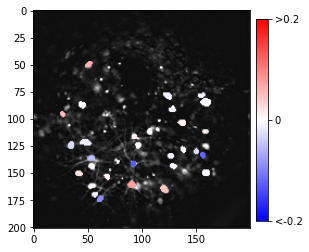

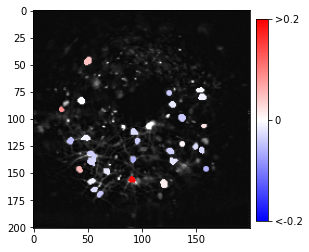

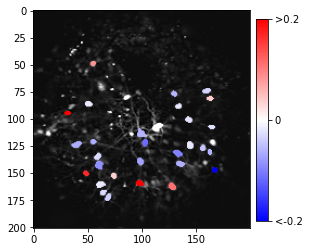

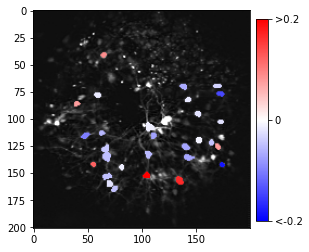

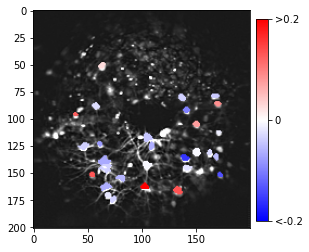

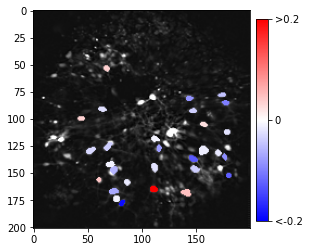

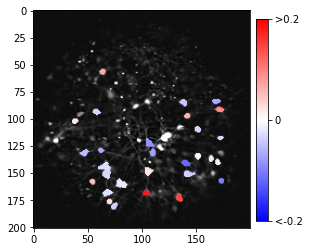

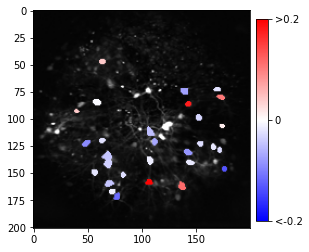

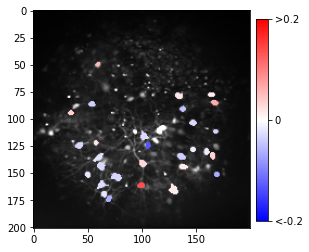

In [395]:
# cells apear in all 5 days
session = sort_file_index
for i in range(len(session)):
    

    # activity dependent overly plot 
    spatial_session = spatial[i][:,assignments_filtered[:,i]].copy() # selected spatial elements 
    background = templates[i].copy()
    activity = Activities[i][assignments_filtered[:,i]] # selected activities
    savepath = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-1-new/000{}_go_9filtered_activity_overlay.png'.format(session[i])
    
    activity_dependent_overlay(spatial_session,background,activity, savepath,colormap = 'bwr')


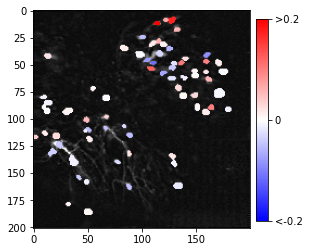

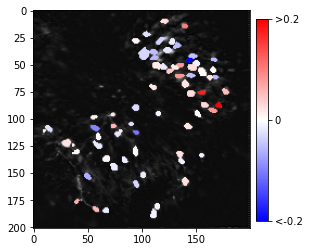

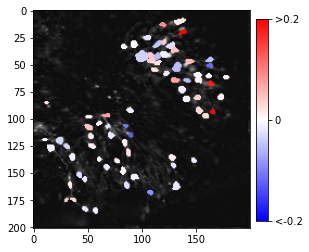

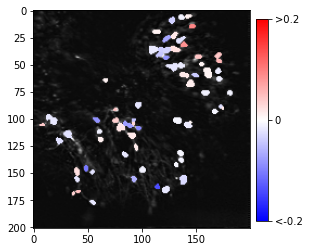

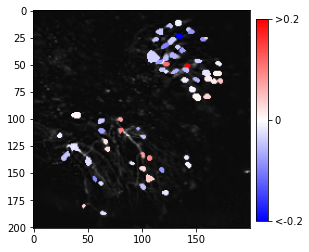

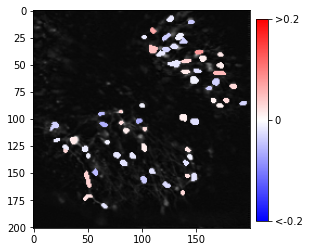

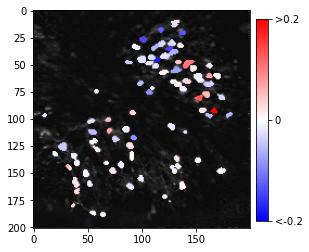

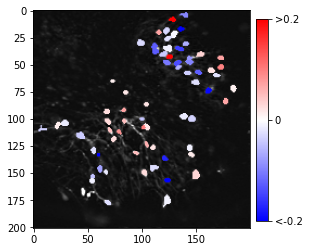

In [55]:
# all the cells
session = sort_file_index
for i in range(len(session)):
    
    # activity dependent overly plot 
    spatial_session = spatial[i].copy() # selected spatial elements 
    background = templates[i].copy()
    activity = Activities[i] # selected activities
    savepath = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-3-new/000{}_go_8all_activity_overlay.png'.format(session[i])
    
    activity_dependent_overlay(spatial_session,background,activity, savepath,colormap = 'bwr')


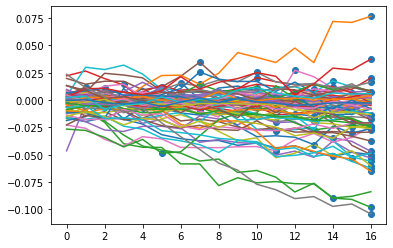

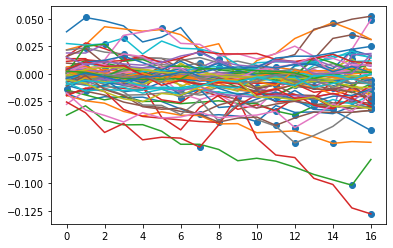

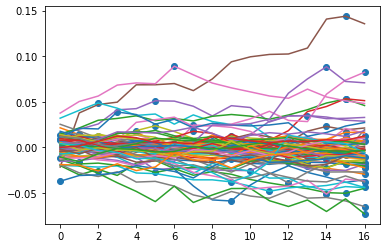

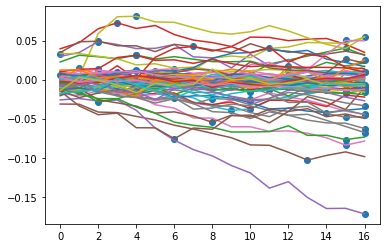

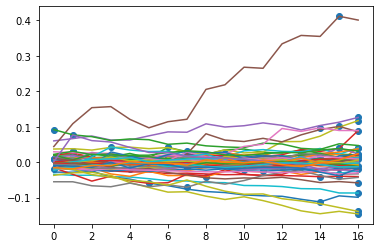

In [57]:
No_Activities = []
session = sort_file_index[0:5]
for index in range(len(session)):
    if nogo_mean_multi[index] is not None:
        x = nogo_mean_multi[index][:,int(nogo_multi_soleopen_frame[index]): int(nogo_multi_soleopen_frame[index] + 3.5*5)]
        peak_index = np.argmax(abs(x),axis = 1)
        peak = np.array([x[i,peak] for i,peak in enumerate(peak_index)])
        No_Activities.append(peak)
        plt.figure()
        plt.plot(x.T)
        plt.scatter(peak_index,peak)
        plt.show()

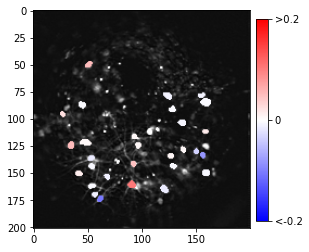

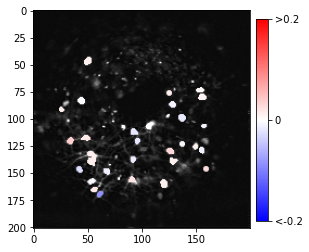

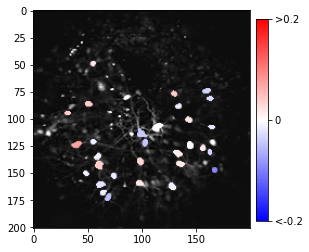

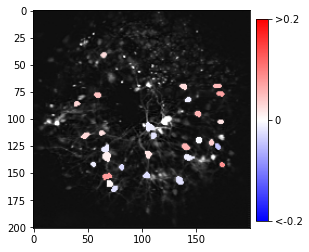

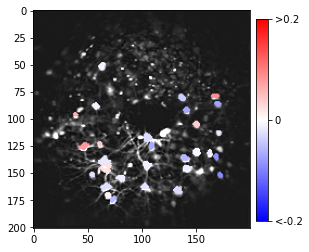

In [404]:
# cells apear in all 5 days

for i in range(len(No_Activities)):
    # activity dependent overly plot 
    spatial_session = spatial[i][:,assignments_filtered[:,i]].copy() # selected spatial elements 
    background = templates[i].copy()
    activity = No_Activities[i][assignments_filtered[:,i]] # selected activities
    savepath = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-1/000{}_nogo_9filtered_activity_overlay.png'.format(session[i])
    
    activity_dependent_overlay(spatial_session,background,activity, savepath,colormap = 'bwr')


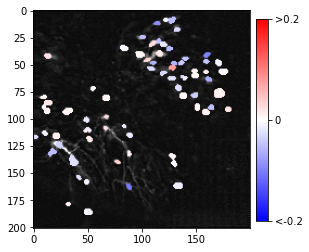

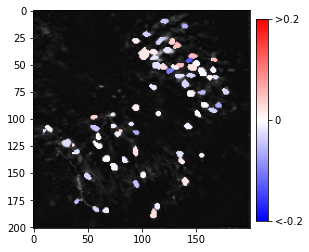

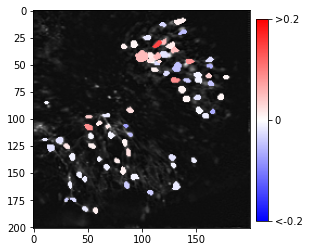

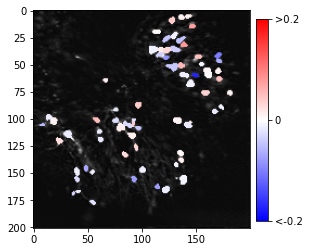

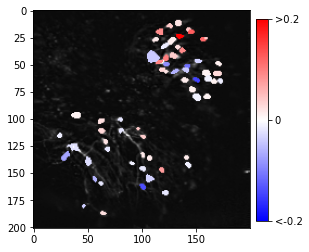

In [58]:

for i in range(len(No_Activities)):
    # activity dependent overly plot 
    spatial_session = spatial[i].copy() # selected spatial elements 
    background = templates[i].copy()
    activity = No_Activities[i] # selected activities
    savepath = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-3-new/000{}_nogo_9all_activity_overlay.png'.format(session[i])
    
    activity_dependent_overlay(spatial_session,background,activity, savepath,colormap = 'bwr')


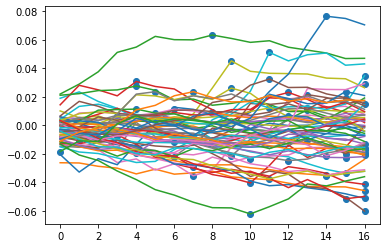

In [126]:
index= 3
x = mean_multi[index][:,int(multi_soleopen_frame[index]): int(multi_soleopen_frame[index] + 3.5*5)]
peak_index = np.argmax(abs(x),axis = 1)
peak = np.array([x[i,peak] for i,peak in enumerate(peak_index)])

plt.plot(x.T)
plt.scatter(peak_index,peak)
plt.show()

## whether selected good neuron response is correlated with licking rate

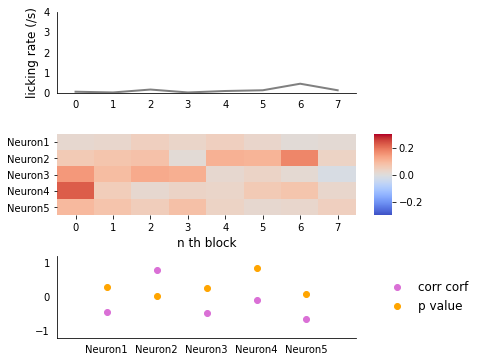

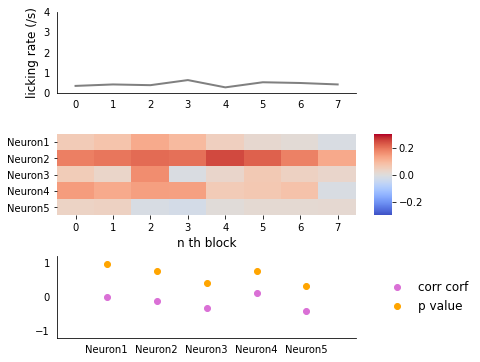

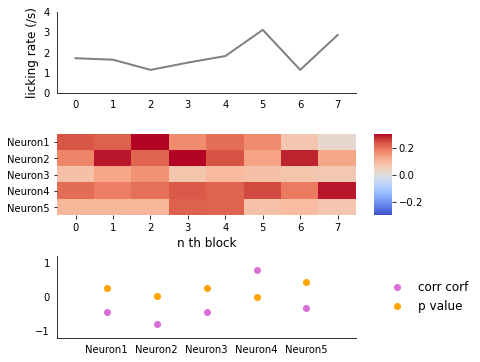

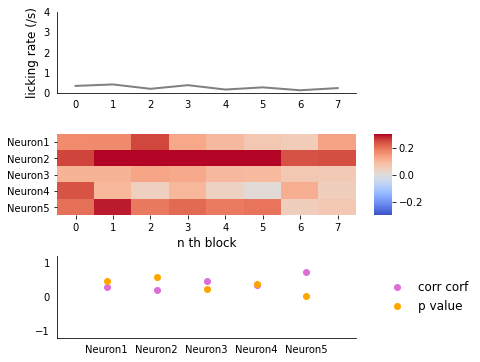

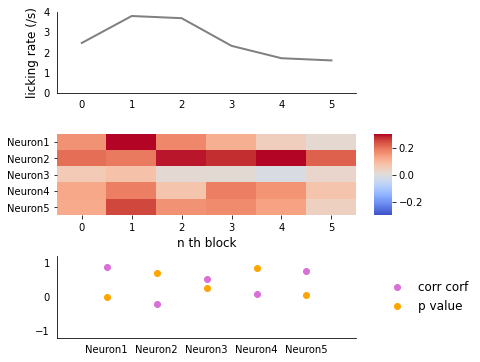

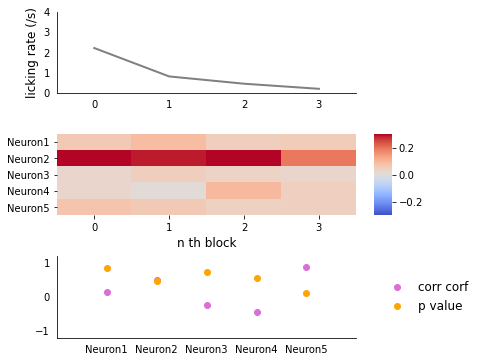

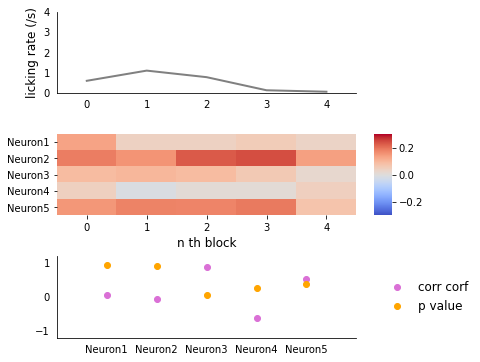

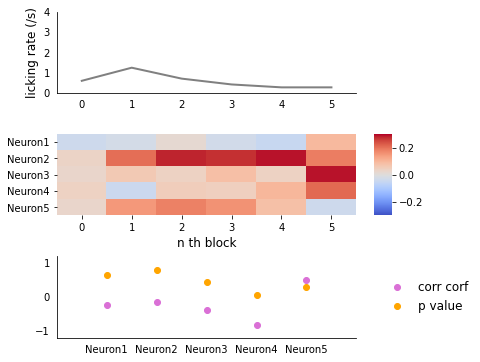

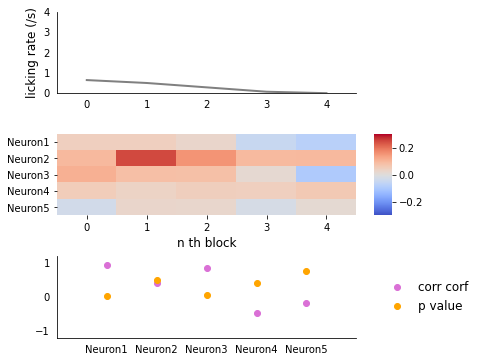

In [477]:
import seaborn as sns
check_index = [2,16,19,22,26]
check_assignments = assignments[check_index,:]
sep_index = 4 # seperation between condition and degradation
for index in range(len(aligned_multi_F_dff_go)):
    block_width = 8
    sele = [int(x) for x in check_assignments[:,index]] # select neurons
    
    dff_matrix = aligned_multi_F_dff_go[index][sele,:]
    new_matrix  = np.zeros([dff_matrix.shape[0],int(np.ceil(dff_matrix.shape[2]/block_width))])
    odor_on_frame = multi_soleopen_frame_go[index]
    # take a block of 8 go trials(from the concept of a bolck of 20 mixed types),find the mean of peak df/f in the delay window
    for i in range(int(np.ceil(dff_matrix.shape[2]/block_width))):
        cell = dff_matrix[:,int(odor_on_frame):int(odor_on_frame+17),i*block_width:min((i+1)*block_width,dff_matrix.shape[2])].copy()
        mean_cell = np.nanmean(cell,axis = 2)
        peak_index = np.argmax(np.abs(mean_cell),axis = 1)
        for j in range(dff_matrix.shape[0]):
            new_matrix[j,i] = mean_cell[j,peak_index[j]]


    # the anticipatory licking rate in the delay window of a block by 8 trials
    big_dict = Dict[index]
    df_all_drop = big_dict['behavior_dropped_df']
    if index <= sep_index:
        index_trialtype = big_dict['dict_index_trialtype']['go']
    else:
        index_trialtype = big_dict['dict_index_trialtype']['OdorReward']
    licking_time = df_all_drop.loc[index_trialtype,'licking'].tolist()
    beh_odor_time = df_all_drop.loc[index_trialtype,'go_odor_on'].tolist()
    lick_times = np.zeros([len(index_trialtype)]) # licking rate in 3.5s anticipatory licking window
    window = 3.5
    for i in range(len(index_trialtype)):
        x = [ant for ant in licking_time[i] if ant > beh_odor_time[i][0] and ant < beh_odor_time[i][0]+window]
        lick_times[i] = len(x)/window
    new_array = np.zeros(int(np.ceil(len(lick_times)/block_width)))
    for i in range(int(np.ceil(len(lick_times)/block_width))):
        mean_lick = np.mean(lick_times[i*block_width:min((i+1)*block_width,len(lick_times))].copy())
        new_array[i] = mean_lick

    # calculate correlation coefficient and p value of each neuron response with licking    
    from scipy.stats import pearsonr
    r_list = []
    p_list = []
    for neuron in range(new_matrix.shape[0]):
        r,p = pearsonr(new_matrix[neuron,:],new_array)
        r_list.append(r)
        p_list.append(p)
        
    
    # plot
    fig = plt.figure(figsize=(6, 6))
    col = 10
    odor_on_frame = int(multi_soleopen_frame_go[index])
    grid = plt.GridSpec(3, col, hspace=0.5, wspace=1)
    main_ax = fig.add_subplot(grid[1,0:col-1])
    lick_ax = fig.add_subplot(grid[0,0:col-1], xticklabels=[], sharex=main_ax)
    mean_ax = fig.add_subplot(grid[2,0:col-1])
    legend_ax = fig.add_subplot(grid[1, col-1])
    legend_ax1 = fig.add_subplot(grid[2, col-1])
    
    x = np.linspace(0,len(new_array)-1,len(new_array))+0.5
    lick_ax.plot(x,new_array,color = 'grey',linewidth = 2)
    lick_ax.set_ylabel('licking rate (/s)',fontsize = 12)
    sns.heatmap(new_matrix,cmap = 'coolwarm',vmin = -0.3,vmax = 0.3,ax = main_ax,cbar_ax=legend_ax)  
    mean_ax.plot(r_list,'o',color = 'orchid',label = 'corr corf')
    mean_ax.plot(p_list,'o',color = 'orange',label = 'p value')

    lick_ax.tick_params(axis="both", which="both", bottom=False, left = False, top = False, right = False) 
    lick_ax.spines["top"].set_visible(False)    
    lick_ax.spines["right"].set_visible(False)
    lick_ax.set_ylim([0,4])
    
    xticks = range(0, 5, 1)
    xticklabels = ['Neuron'+str(int(y+1)) for y in xticks]
    main_ax.set_yticklabels(xticklabels, rotation = 0)
    main_ax.set_xlabel('n th block',fontsize = 12)

    mean_ax.tick_params(axis="both", which="both", bottom=False, left = False, top = False, right = False) 
    mean_ax.spines["top"].set_visible(False)    
    mean_ax.spines["right"].set_visible(False)
    mean_ax.set_ylim([-1.2,1.2])
    mean_ax.set_xlim([-1,5])
    mean_ax.set_xticks(xticks)
    mean_ax.set_xticklabels(xticklabels)
    handles, labels = mean_ax.get_legend_handles_labels()
    
    legend_ax1.legend(handles, labels,loc='center left',frameon=False,fontsize = 12)
    legend_ax1.tick_params(axis="both", which="both",labelleft=False,labelbottom=False, bottom=False, left = False, top = False, right = False) 
    legend_ax1.spines["top"].set_visible(False)    
    legend_ax1.spines["right"].set_visible(False)
    legend_ax1.spines["bottom"].set_visible(False)    
    legend_ax1.spines["left"].set_visible(False)

    name = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-1-new/000{}_blockby8_OTGC1_NEURON2_16_19_22_26'.format(sort_file_index[index])
    plt.savefig("{}.png".format(name), bbox_inches="tight", dpi = 200)
    plt.show()

In [75]:
assignments_selected.shape

(40, 9)

## examine the reward 

In [15]:
index = [i for i in range(len(assignments)) if np.sum(~np.isnan(assignments), axis=1)[i] in [8,9]]
assignments_selected = np.array(assignments[index], dtype=int)

In [16]:
assignments_selected


array([[         55,          52,          63,          65,          81,
                 72,          59,          68,          58],
       [         21,          22,          29,          24,          40,
                 32,          19,          31,          17],
       [         54,          51,          64,          64,          80,
                 76,          57,          70,          56],
       [         51,          48,          56,          59,          76,
                 66,          52,          63,          53],
       [         50,          47,          57,          58,          75,
                 68,          51,          64,          52],
       [         48,          46,          54,          56,          73,
                 63,          48,          61,          50],
       [         31,          27,          32,          35,          50,
                 37,          26,          34,          27],
       [         58,          55,          66,          69,   

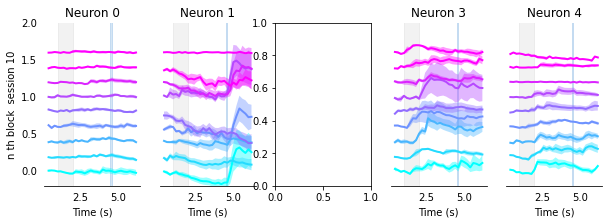

In [41]:
ses_index = 8
picked_neuron_ses1 = assignments_selected[[26,12,37,16,19],ses_index]

ses1_dff = aligned_multi_F_dff_go[ses_index]
ses1_openframe = multi_soleopen_frame_go[ses_index]
block_width = 4
fig,ax = plt.subplots(1,5,figsize = (10,3))
colormap = "cool"
cmap = mpl.cm.get_cmap(colormap) 
for j,index in enumerate(picked_neuron_ses1):
    try:
        dff = ses1_dff[index]
    
        # odor shaded area
        ax[j].fill_between([1,2], [10,10],[-10,-10],facecolor="grey", color='grey', alpha=0.1)   
        # lick shaded area
        ax[j].fill_between([4.5,4.58], [10,10],[-10,-10],facecolor="#3083D1", color='#3083D1',alpha=0.2)
        for i in range(int(np.ceil(dff.shape[1]/block_width))):
                block = dff[int(ses1_openframe-5):int(ses1_openframe+25),i*block_width:min((i+1)*block_width,dff.shape[1])].copy()
                mu = np.nanmean(block,axis=1)
                adjusted_sigma = np.nanstd(block,axis=1)/np.sqrt(block.shape[1])
                x = np.linspace(0+0.4,(len(mu)+1)/5,len(mu))
                # plot
                color = cmap(i/7)
                ax[j].plot(x,mu+i/5, lw=2,  color = color,label = 'block {}'.format(i) )

                ax[j].fill_between(x,mu+adjusted_sigma+i/5,mu-adjusted_sigma+i/5, facecolor= color, alpha=0.4)   

                ax[j].set_ylim(-0.2,2)
                ax[j].set_title(r'Neuron {}'.format(j))
        #         axes[row_plot, col_plot].legend(loc='best',frameon=False)
                ax[j].set_xlabel('Time (s)')
                ax[j].set_ylabel('n th block  session {}'.format(sort_file_index[ses_index]) if j == 0 else '')
    #             ax[j].legend(loc = 'best')


                # decorations
                ax[j].tick_params(axis="both", which="both", labelleft=False if j != 0 else True ,bottom=False, left = False, top = False, right = False) 
                ax[j].spines["top"].set_visible(False)    
                ax[j].spines["right"].set_visible(False)
    #             ax[j].spines["bottom"].set_visible(False if row_plot != row-1 else True)    
                ax[j].spines["left"].set_visible(False)
    except:
        pass
name = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-1-0612/000{}_blockby8_water_response_NEURON2_11_12_29_37'.format(sort_file_index[ses_index])
plt.savefig("{}.png".format(name), bbox_inches="tight", dpi = 200)
plt.savefig("{}.svg".format(name), bbox_inches="tight", dpi = 200)
plt.show()        

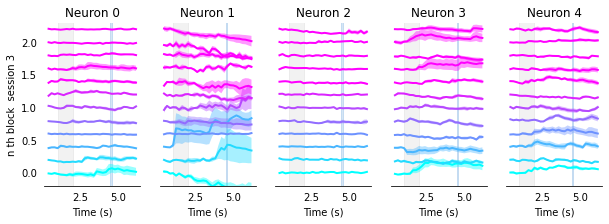

In [56]:
ses_index = 2
picked_neuron_ses1 = assignments_selected[[26,12,37,16,19],ses_index]

ses1_dff = nogo_aligned_multi_F_dff[ses_index]
ses1_openframe = nogo_multi_soleopen_frame[ses_index]
block_width = 4
fig,ax = plt.subplots(1,5,figsize = (10,3))
colormap = "cool"
cmap = mpl.cm.get_cmap(colormap) 
for j,index in enumerate(picked_neuron_ses1):
    try:
        dff = ses1_dff[index]
    
        # odor shaded area
        ax[j].fill_between([1,2], [10,10],[-10,-10],facecolor="grey", color='grey', alpha=0.1)   
        # lick shaded area
        ax[j].fill_between([4.5,4.58], [10,10],[-10,-10],facecolor="#3083D1", color='#3083D1',alpha=0.2)
        for i in range(int(np.ceil(dff.shape[1]/block_width))):
                block = dff[int(ses1_openframe-5):int(ses1_openframe+25),i*block_width:min((i+1)*block_width,dff.shape[1])].copy()
                mu = np.nanmean(block,axis=1)
                adjusted_sigma = np.nanstd(block,axis=1)/np.sqrt(block.shape[1])
                x = np.linspace(0+0.4,(len(mu)+1)/5,len(mu))
                # plot
                color = cmap(i/7)
                ax[j].plot(x,mu+i/5, lw=2,  color = color,label = 'block {}'.format(i) )

                ax[j].fill_between(x,mu+adjusted_sigma+i/5,mu-adjusted_sigma+i/5, facecolor= color, alpha=0.4)   

                ax[j].set_ylim(-0.2,2.3)
                ax[j].set_title(r'Neuron {}'.format(j))
        #         axes[row_plot, col_plot].legend(loc='best',frameon=False)
                ax[j].set_xlabel('Time (s)')
                ax[j].set_ylabel('n th block  session {}'.format(sort_file_index[ses_index]) if j == 0 else '')
    #             ax[j].legend(loc = 'best')


                # decorations
                ax[j].tick_params(axis="both", which="both", labelleft=False if j != 0 else True ,bottom=False, left = False, top = False, right = False) 
                ax[j].spines["top"].set_visible(False)    
                ax[j].spines["right"].set_visible(False)
    #             ax[j].spines["bottom"].set_visible(False if row_plot != row-1 else True)    
                ax[j].spines["left"].set_visible(False)
    except:
        pass
name = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-1-0612/000{}_nogo_blockby4_water_response_NEURON2_11_12_29_37'.format(sort_file_index[ses_index])
plt.savefig("{}.png".format(name), bbox_inches="tight", dpi = 200)
plt.savefig("{}.svg".format(name), bbox_inches="tight", dpi = 200)
plt.show()   

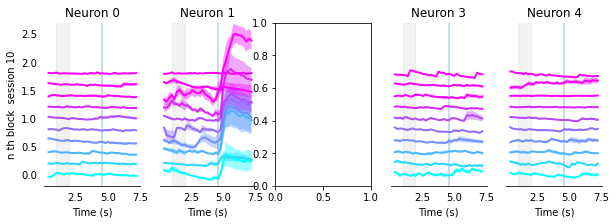

In [55]:
ses_index = 8
picked_neuron_ses1 = assignments_selected[[26,12,37,16,19],ses_index]

ses1_dff = bg_aligned_multi_F_dff[ses_index]
ses1_openframe = bg_multi_soleopen_frame[ses_index]
block_width = 4
fig,ax = plt.subplots(1,5,figsize = (10,3))
colormap = "cool"
cmap = mpl.cm.get_cmap(colormap) 
for j,index in enumerate(picked_neuron_ses1):
    try:
        dff = ses1_dff[index]
    
        # odor shaded area
        ax[j].fill_between([1,2], [10,10],[-10,-10],facecolor="grey", color='grey', alpha=0.1)   
        # lick shaded area
        ax[j].fill_between([4.5,4.58], [10,10],[-10,-10],facecolor="#3083D1", color='#3083D1',alpha=0.2)
        for i in range(int(np.ceil(dff.shape[1]/block_width))):
                block = dff[int(ses1_openframe-22.5):int(ses1_openframe+12.5),i*block_width:min((i+1)*block_width,dff.shape[1])].copy()
                mu = np.nanmean(block,axis=1)
                adjusted_sigma = np.nanstd(block,axis=1)/np.sqrt(block.shape[1])
                x = np.linspace(0+0.4,(len(mu)+1)/5,len(mu))
                # plot
                color = cmap(i/7)
                ax[j].plot(x,mu+i/5, lw=2,  color = color,label = 'block {}'.format(i) )

                ax[j].fill_between(x,mu+adjusted_sigma+i/5,mu-adjusted_sigma+i/5, facecolor= color, alpha=0.4)   

                ax[j].set_ylim(-0.2,2.7)
                ax[j].set_title(r'Neuron {}'.format(j))
        #         axes[row_plot, col_plot].legend(loc='best',frameon=False)
                ax[j].set_xlabel('Time (s)')
                ax[j].set_ylabel('n th block  session {}'.format(sort_file_index[ses_index]) if j == 0 else '')
    #             ax[j].legend(loc = 'best')


                # decorations
                ax[j].tick_params(axis="both", which="both", labelleft=False if j != 0 else True ,bottom=False, left = False, top = False, right = False) 
                ax[j].spines["top"].set_visible(False)    
                ax[j].spines["right"].set_visible(False)
    #             ax[j].spines["bottom"].set_visible(False if row_plot != row-1 else True)    
                ax[j].spines["left"].set_visible(False)
    except:
        pass
name = 'D:/PhD/Microscope/Selina/imaging_data/new_figures/OT-GC-1-0612/000{}_unpredwater_blockby4_water_response_NEURON2_11_12_29_37'.format(sort_file_index[ses_index])
plt.savefig("{}.png".format(name), bbox_inches="tight", dpi = 200)
plt.savefig("{}.svg".format(name), bbox_inches="tight", dpi = 200)
plt.show()   

## Combining data of components over multiple sessions

Now that all sessions are aligned and we have a list of re-registered neurons, we can use `assignments` and `matchings` to collect traces from neurons over different sessions.

As an exercise, we can collect the traces of all neurons that were registered in all sessions. We already gathered the indices of these neurons in the previous cell in `assignments_filtered`. Assuming that traces of each session are saved in their own `CNMF` object collected in a list, we can iterate through `assignments_filtered` and use these indices to find the re-registered neurons in every session.

Note: This notebook does not include the traces of the extracted neurons, only their spatial components. As such the loop below will produce an error. However, it demonstrates how to use the results of the registration to in your own analysis to extract the traces of the same neurons across different sessions.

In [ ]:
traces = np.zeros(assignments_filtered.shape, dtype=np.ndarray)
for i in range(traces.shape[0]):
    for j in range(traces.shape[1]):
        traces[i,j] = cnm_list[j].estimates.C[int(assignments_filtered[i,j])]

Now we have the array `traces`, where element `traces[i,j] = k` is the temporal component of neuron `i` at session `j`. This can be performed with `F_dff` data or `S` spikes as well.

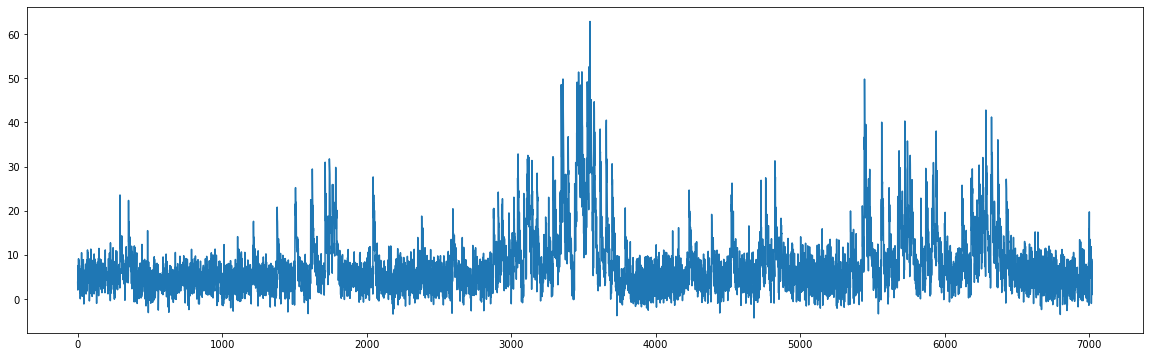

In [29]:
## my way of using moving window to calculate zscore

neuron = 10
denoised = C[0][neuron,:]+YrA[0][neuron,:]*0.1
w = 1000
space = [w]*int(np.floor(len(C[0][neuron,:])/w))+[len(C[0][neuron,:])%w]
cum = np.cumsum(space)
cum = np.insert(cum,0,0)

zscore_window = np.zeros([len(C[0][neuron,:])])
plt.figure(figsize=(20,6))
for i in range(len(cum)-1):
    window = denoised[cum[i]:cum[i+1]]
    quantile10 = np.quantile(window, 0.08)
    std = np.nanstd(window[window<quantile10])
    mean = np.nanmean(window[window<quantile10])
    zscore_window[cum[i]:cum[i+1]] = (window-mean)/std
plt.plot(zscore_window)

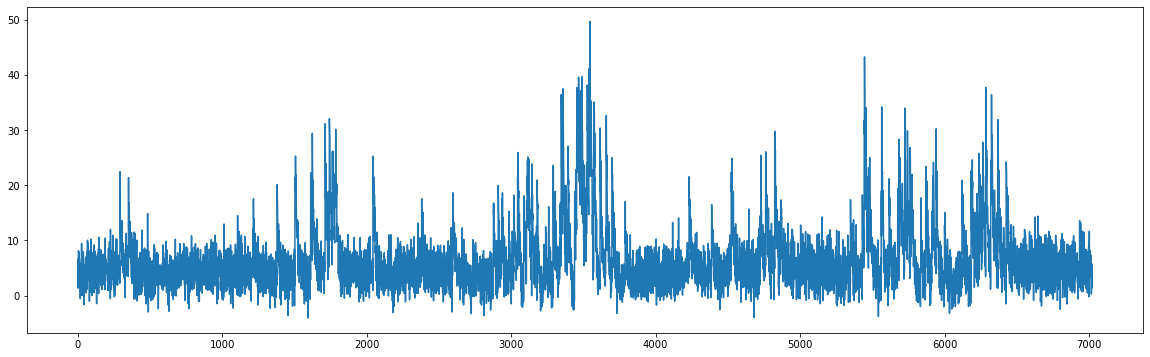

In [32]:
neuron = 10
denoised = great_F_df[neuron,:]
w = 1500
space = [w]*int(np.floor(len(C[0][neuron,:])/w))+[len(C[0][neuron,:])%w]
cum = np.cumsum(space)
cum = np.insert(cum,0,0)

zscore_window = np.zeros([len(C[0][neuron,:])])
plt.figure(figsize=(20,6))
for i in range(len(cum)-1):
    window = denoised[cum[i]:cum[i+1]]
    quantile10 = np.quantile(window, 0.1)
    std = np.nanstd(window[window<quantile10])
    mean = np.nanmean(window[window<quantile10])
    zscore_window[cum[i]:cum[i+1]] = (window-mean)/std
plt.plot(zscore_window)